This notebook opens the Greenland FirnCover data and puts it into pandas dataframes.
The core data comes from core_data_df.pkl, which is created by running firncover_core_data_df.py
(The dataframe is created in that script.)

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import tables as tb
import datetime
import pandas as pd
import time
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # turn off future warning for frame.append
pd.options.mode.chained_assignment = None # turn off chained assignment warning, default = 'warn'

from FirnCover_lib import R, BDOT_TO_A, RHO_W_KGM, P_0, epoch
import FirnCover_lib as fcl

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

np.seterr(invalid='ignore')
# %matplotlib inline
# %matplotlib qt

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Default Settings for figures

sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': False})
fontsz = 20
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams['axes.titlesize'] = 22
plt.rcParams["axes.labelsize"] = 22
plt.rcParams['figure.figsize'] = [10, 8]
palette = sns.color_palette()

In [13]:
#%% Loading data
# Things to change
figex = '_200504.png' #extension for figures (name plus type)
pathtodata = os.getcwd()
date1 = '2021_07_30' # Date on the hdf5 file
sites=['Summit','KAN-U','NASA-SE','Crawford','EKT','Saddle','EastGrip','DYE-2']

In [14]:
### Import the FirnCover data tables. 
filename='FirnCoverData_2_0_' + date1 + '.h5'
filepath=os.path.join(pathtodata,filename)
compaction_df, airtemp_df, inst_meta_df = fcl.import_firncover_dataset(filepath)

# Loading side data
statmeta_df, sonic_df, rtd_df, rtd_trun, rtd_dep,metdata_df = fcl.load_metadata(compaction_df,filepath,sites)

Reading /Users/cdsteve2/research/firn/firncover/FirnCoverData_2_0_2021_07_30.h5
contains:
   Air_Temp_Hourly
       sitename
       daynumber_YYYYMMDD
       hournumber_HH
       air_temp_C
   Compaction_Daily
       sitename
       daynumber_YYYYMMDD
       instrument_id
       compaction_ratio
       compaction_wire_correction_ratio
       compaction_cable_distance_m
       compaction_borehole_length_m
       borehole_depth_top_m
       borehole_depth_bottom_m
   Compaction_Instrument_Metadata
       instrument_ID
       sitename
       installation_daynumber_YYYYMMDD
       borehole_top_from_surface_m
       borehole_bottom_from_surface_m
       borehole_initial_length_m
       instrument_has_wire_correction
       direction_from_tower_degrees
       distance_from_tower_m
       borehole_ID
       borehole_ID_is_direct
   Firn_Temp_Daily
       sitename
       daynumber_YYYYMMDD
       RTD_ohms_avg
       RTD_ohms_max
       RTD_temp_avg_uncorrected_C
       RTD_temp_max_uncorrected

[13, '2018-02-20', 'end']
[10, '2019-07-29', 'end']
[42, 'start', '2017-10-14']
[48, 'start', '2017-10-18']
[48, '2018-05-27', '2018-07-19']
[1, 'start', '2013-12-01']
[35, 'start', '2016-09-15']
[43, '2018-07-16', 'end']


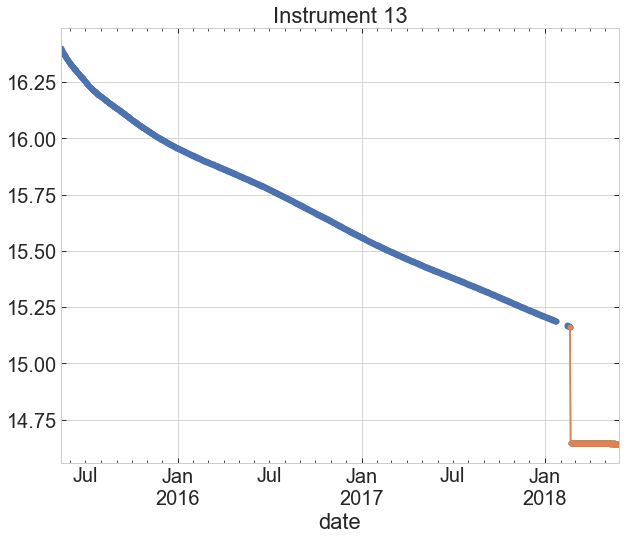

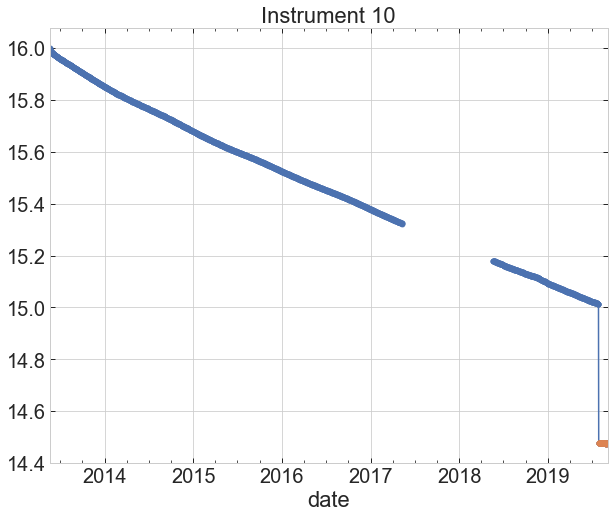

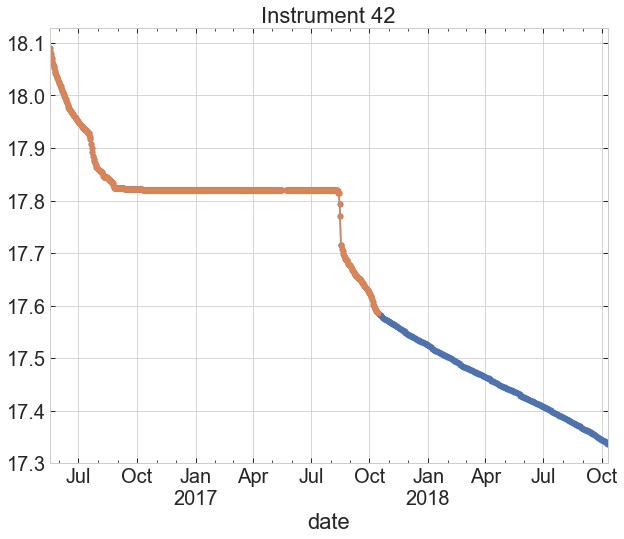

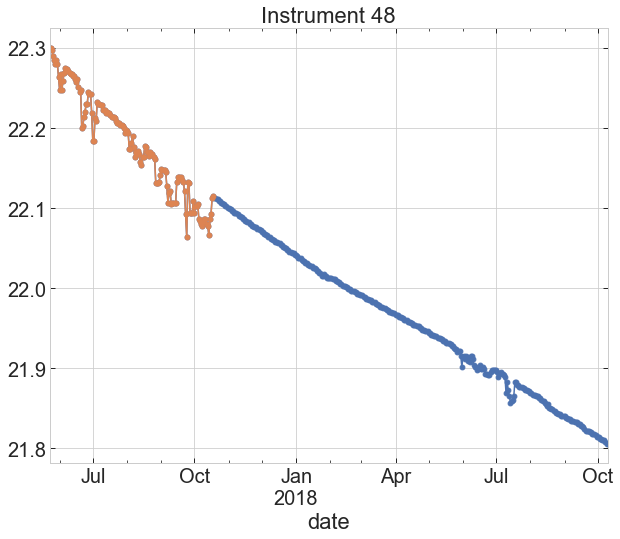

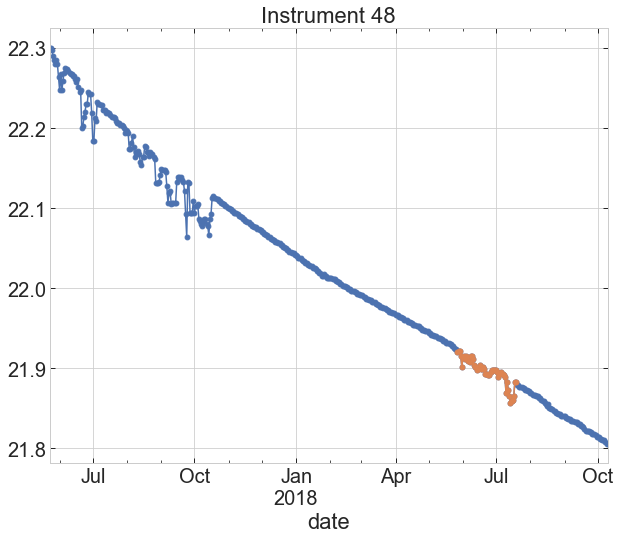

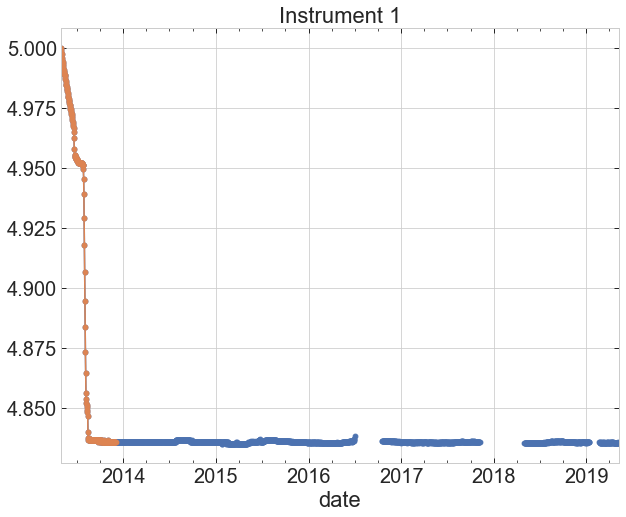

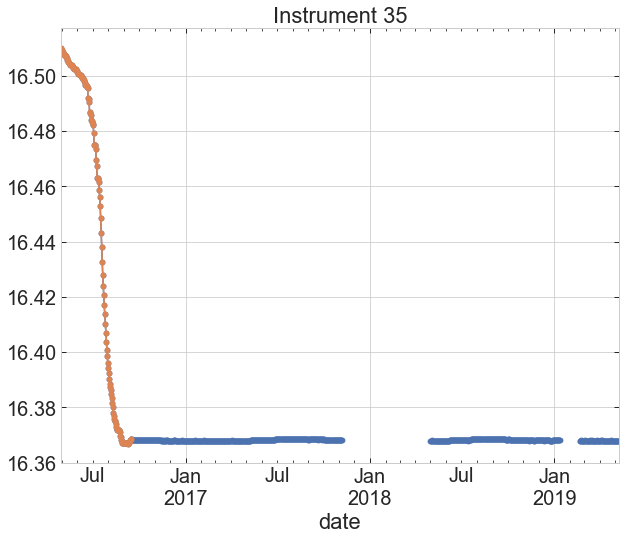

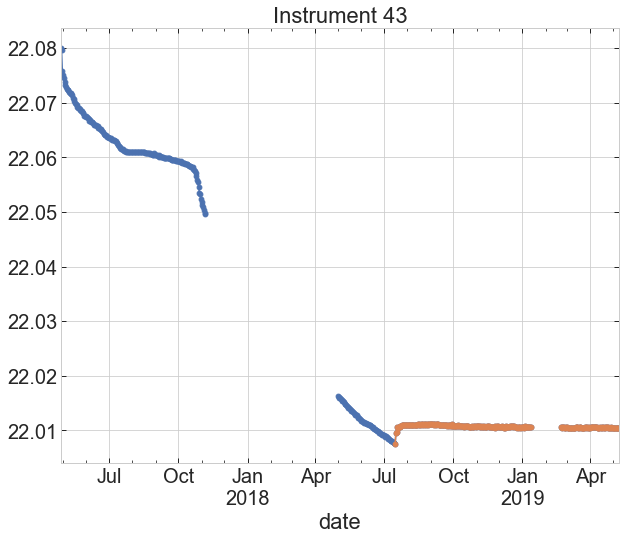

In [16]:
# %% Plotting erroneous periods removed from analysis
erroneous_periods = [[13,'2018-02-20','end'] , 
    [10,'2019-07-29','end'] ,
    [42,'start','2017-10-14'] ,
    [48,'start','2017-10-18'] , 
    [48,'2018-05-27','2018-07-19'] ,
    [1,'start','2013-12-01'] ,
    [35,'start','2016-09-15'] ,
    [43,'2018-07-16','end'] ] 

for i in range(len(erroneous_periods)):
    print(erroneous_periods[i])

    if erroneous_periods[i][1] == 'start':
        tmp = compaction_df.loc[erroneous_periods[i][0],
                          'compaction_borehole_length_m'].loc[:erroneous_periods[i][2]]
    elif erroneous_periods[i][2] == 'end':
        tmp = compaction_df.loc[erroneous_periods[i][0],
                                'compaction_borehole_length_m'].loc[erroneous_periods[i][1]:]
    else: 
        tmp = compaction_df.loc[erroneous_periods[i][0],
                          'compaction_borehole_length_m'].loc[erroneous_periods[i][1]:erroneous_periods[i][2]]
    
    if len(tmp.loc[tmp.notnull()])==0:
        print('already removed')
        continue
    fig = plt.figure()
    compaction_df.loc[erroneous_periods[i][0],'compaction_borehole_length_m'].plot(marker='o')
    tmp.plot(marker='o')
    plt.title('Instrument '+str(erroneous_periods[i][0]))
    fig.savefig('figures/err_instr_'+str(erroneous_periods[i][0])+'.png')
# %% Removing erroneous periods from the analysis
compaction_df.loc[13,'compaction_borehole_length_m'].loc['2018-02-20':] = np.nan
compaction_df.loc[10,'compaction_borehole_length_m'].loc['2019-07-29':] = np.nan
compaction_df.loc[42,'compaction_borehole_length_m'].loc[:'2017-10-14'] = np.nan
compaction_df.loc[48,'compaction_borehole_length_m'].loc[:'2017-10-18'] = np.nan
compaction_df.loc[48,'compaction_borehole_length_m'].loc['2018-05-27':'2018-07-19'] = np.nan
compaction_df.loc[1,'compaction_borehole_length_m'].loc[:'2013-12-01'] = np.nan
compaction_df.loc[35,'compaction_borehole_length_m'].loc[:'2016-09-01'] = np.nan
compaction_df.loc[43,'compaction_borehole_length_m'].loc['2018-07-16':] = np.nan 

In [17]:
#%% calculating borehole shortening
compaction_df = compaction_df.assign(borehole_length_m_smoothed = 0*compaction_df['compaction_borehole_length_m'])
compaction_df = compaction_df.assign( borehole_shortening_m = 0*compaction_df['compaction_borehole_length_m'])
compaction_df = compaction_df.assign( delta_L_m_smoothed = 0*compaction_df['compaction_borehole_length_m'])

ind_start = 60
count = -1
for site in sites:
    count = count+1
    ind_instr = inst_meta_df.loc[inst_meta_df['sitename'] == site].index
    
    for instr_nr in ind_instr:
        if  np.isin(instr_nr, np.unique(compaction_df.index.get_level_values(0))):
            if compaction_df.loc[instr_nr,'compaction_borehole_length_m'].shape[0]>ind_start:
                
                tmp =  compaction_df.loc[instr_nr,'compaction_borehole_length_m'].values
                tmp[:ind_start] = np.nan
                compaction_df.loc[instr_nr,'compaction_borehole_length_m'] = tmp
                compaction_df.loc[instr_nr,'borehole_length_m_smoothed'] = compaction_df.loc[instr_nr,'compaction_borehole_length_m'].rolling(60,center=True, win_type='gaussian',min_periods=50).mean(std=5).values
                time_start =  compaction_df.loc[instr_nr,'compaction_borehole_length_m'][ind_start:].first_valid_index()
                compaction_df.loc[instr_nr,'borehole_shortening_m'] = - compaction_df.loc[instr_nr,'compaction_borehole_length_m'].loc[time_start] + compaction_df.loc[instr_nr,'compaction_borehole_length_m'].values

                                
                compaction_df.loc[instr_nr,'delta_L_m_smoothed'] = - compaction_df.loc[instr_nr,'borehole_length_m_smoothed'].loc[time_start]  + compaction_df.loc[instr_nr,'borehole_length_m_smoothed'].values
                
msk = compaction_df['borehole_shortening_m']>0
compaction_df.loc[msk,'borehole_shortening_m'] = np.nan
msk = compaction_df['delta_L_m_smoothed']>0
compaction_df.loc[msk,'delta_L_m_smoothed'] = np.nan
                
msk = compaction_df['compaction_borehole_length_m'].isna()
compaction_df.loc[msk,'borehole_length_m_smoothed'] = np.nan
compaction_df.loc[msk,'borehole_shortening_m'] = np.nan
compaction_df.loc[msk,'delta_L_m_smoothed'] = np.nan

Summit
KAN-U
NASA-SE
Crawford
EKT
Saddle
EastGrip
DYE-2


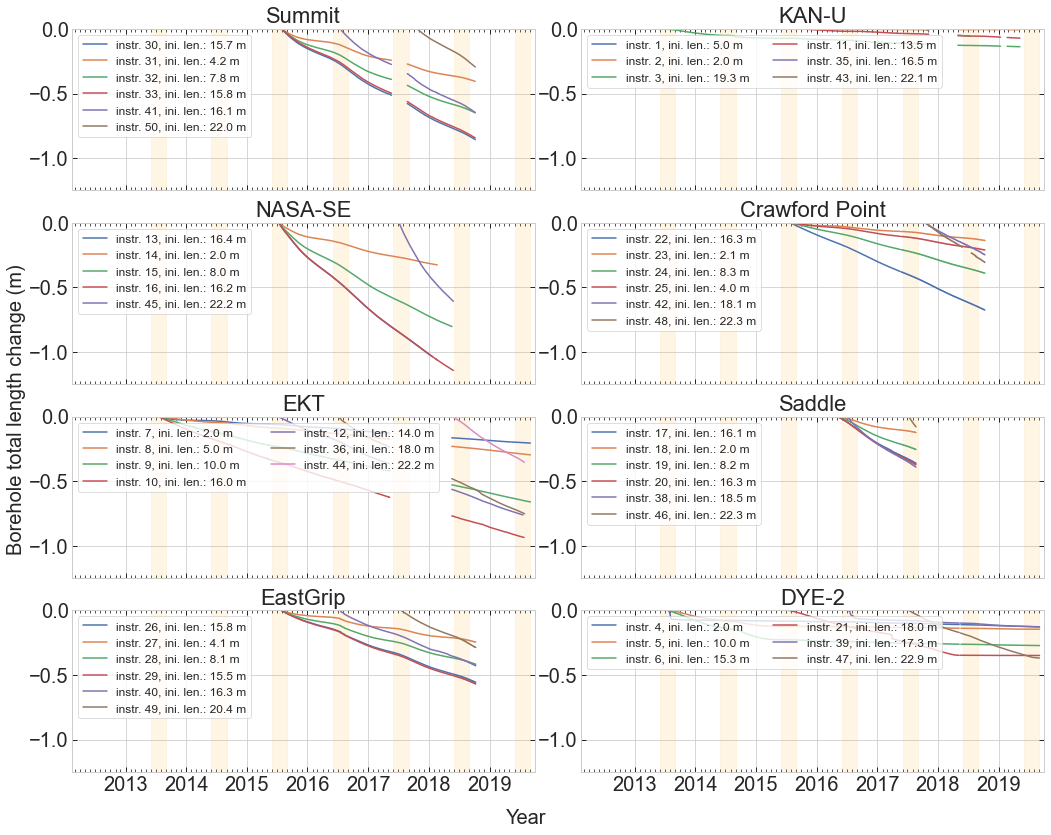

In [18]:
#% plotting borehole length
f, ax = fcl.multi_plot(inst_meta_df, compaction_df,
           var = 'borehole_shortening_m',
           sites = sites, sp1 = 4, sp2 = 2,
           title =  'Borehole total length change (m)',
           filename_out ='borehole_shortening_m')
for k in range(np.size(ax)):
    i,j = np.unravel_index(k, ax.shape)
    ax[i,j].set_ylim((-1.25,0))
plt.show()
# f.savefig('figures/fig4_borehole_shortening_m.tiff', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
# f.savefig('figures/fig4_borehole_shortening_m.pdf')

Summit
KAN-U
NASA-SE
Crawford
EKT
Saddle
EastGrip
DYE-2


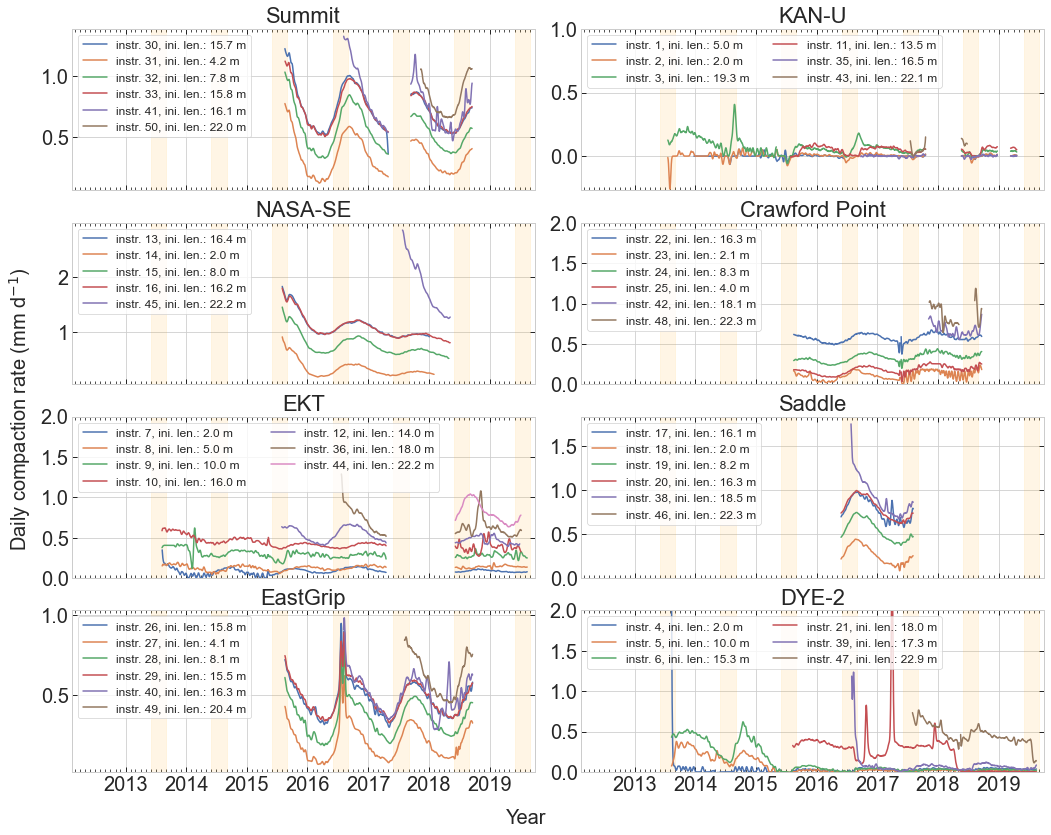

In [19]:
#%% daily compaction
compaction_df = compaction_df.assign(daily_compaction_md = np.nan*compaction_df['compaction_borehole_length_m'])

compaction_df['daily_compaction_md'] = compaction_df.groupby(level=0)['compaction_borehole_length_m'].diff()*1000

compaction_df = compaction_df.assign(daily_compaction_md_smoothed = np.nan*compaction_df['borehole_length_m_smoothed'])

compaction_df['daily_compaction_md_smoothed'] = - compaction_df.groupby(level=0)['borehole_length_m_smoothed'].diff()*1000

msk = compaction_df['borehole_length_m_smoothed'].isna()
compaction_df.loc[msk,'daily_compaction_md'] = np.nan
compaction_df.loc[msk,'daily_compaction_md_smoothed'] = np.nan

f, ax = fcl.multi_plot(inst_meta_df, compaction_df,
           var = 'daily_compaction_md_smoothed',
           sites = sites, sp1 = 4, sp2 = 2,
           title =  'Daily compaction rate (mm d$^{-1}$)',  
           filename_out ='daily_compaction_md_smoothed')

ax[0,1].set_ylim((-0.27, 1))
ax[2,0].set_ylim((0, 2))
ax[1,1].set_ylim((0, 2))
ax[3,1].set_ylim((0,2))
plt.show()
# f.savefig('figures/fig5_daily_compaction_md_smoothed.tiff', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
# f.savefig('figures/fig5_daily_compaction_md_smoothed.pdf')

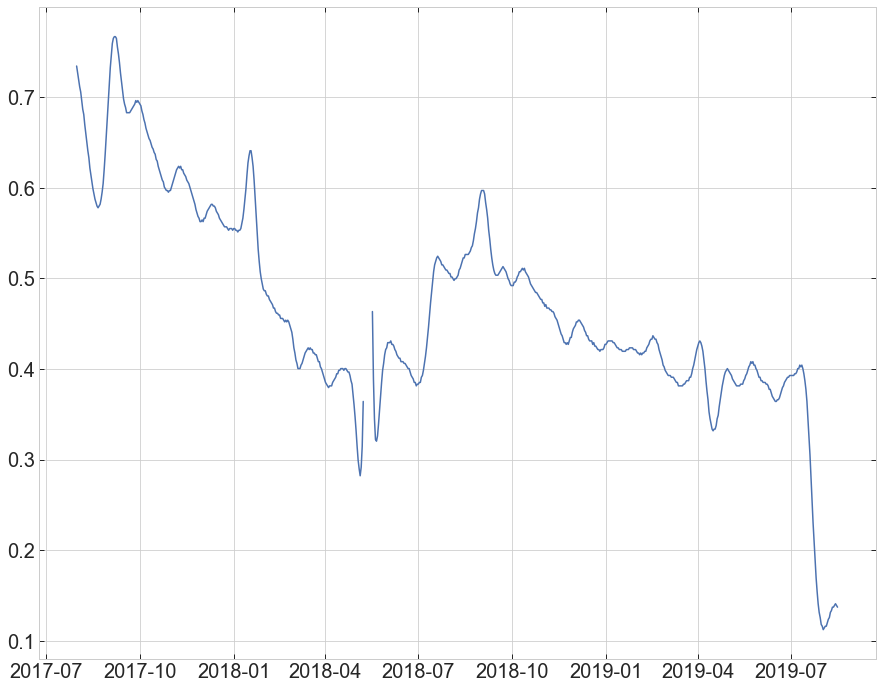

In [24]:
#%% Summit daily compaction
compaction_df = compaction_df.assign(daily_compaction_md = np.nan*compaction_df['compaction_borehole_length_m'])

compaction_df['daily_compaction_md'] = compaction_df.groupby(level=0)['compaction_borehole_length_m'].diff()*1000

compaction_df = compaction_df.assign(daily_compaction_md_smoothed = np.nan*compaction_df['borehole_length_m_smoothed'])

compaction_df['daily_compaction_md_smoothed'] = - compaction_df.groupby(level=0)['borehole_length_m_smoothed'].diff()*1000

msk = compaction_df['borehole_length_m_smoothed'].isna()
compaction_df.loc[msk,'daily_compaction_md'] = np.nan
compaction_df.loc[msk,'daily_compaction_md_smoothed'] = np.nan

def single_plot(inst_meta_df, compaction_df, var = 'daily_compaction_md',
               var2 = '',
               sites = '', sp1 = 4, sp2 = 2,
               title = '', filename_out = 'plot'):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')
    f1, ax = plt.subplots(figsize=(15, 12))
    var = 'daily_compaction_md_smoothed'
    ini_depth = inst_meta_df.loc[inst_meta_df.index.values == instr_nr,
                                     'borehole_initial_length_m']
    ax.plot(compaction_df.loc[instr_nr,var].resample('D').asfreq(),
                                 label='instr. '+str(instr_nr)+', ini. len.: %0.1f m'%abs(ini_depth))
    return f1, ax
    
f, ax = single_plot(inst_meta_df, compaction_df,
       var = 'daily_compaction_md_smoothed',
       sites = 'Summit', sp1 = 4, sp2 = 2,
       title =  'Daily compaction rate (mm d$^{-1}$)',  
       filename_out ='daily_compaction_md_smoothed')

# ax.set_title('Daily compaction rate (mm d$^{-1}$)')
# ax[0,1].set_ylim((-0.27, 1))
# ax[2,0].set_ylim((0, 2))
# ax[1,1].set_ylim((0, 2))
# ax[3,1].set_ylim((0,2))
plt.show()
# f.savefig('figures/fig5_daily_compaction_md_smoothed.tiff', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
# f.savefig('figures/fig5_daily_compaction_md_smoothed.pdf')

In [25]:
pd.DataFrame(metdata_df)

,sitename,daynumber_YYYYMMDD,battery_min_V,battery_max_V,panel_temp_mean_C,air_temp_min_C,air_temp_median_C,air_temp_max_C,sonic_range_quality,sonic_range_quality_code,sonic_range_dist_raw_m,sonic_range_air_temp_C,sonic_range_dist_corrected_m,accum_snow_depth_m,accum_snow_depth_interpolated_m,accum_snow_depth_interpolated_flag,date
735,KAN-U,20150505,13.43,14.31,-11.720000,-13.670000,-13.190000,-10.900000,199,0,2.804,-13.670000,2.732935,0.000000,0.000000,0,2015-05-05
736,KAN-U,20150506,13.32,14.93,-9.570000,-16.889999,-10.650000,-6.382000,182,0,2.825,-16.709999,2.737226,-0.004291,-0.004291,0,2015-05-06
737,KAN-U,20150507,13.41,14.84,-7.835000,-15.510000,-11.500000,-3.858000,185,0,2.668,-3.858000,2.649091,0.083844,0.083844,0,2015-05-07
738,KAN-U,20150508,13.43,14.91,-8.830000,-17.469999,-8.620000,-4.530000,185,0,2.693,-17.030001,2.607699,0.125236,0.125236,0,2015-05-08
739,KAN-U,20150509,13.48,14.65,-8.170000,-12.150000,-9.500000,-8.710000,168,0,2.575,-12.150000,2.517079,0.215856,0.215856,0,2015-05-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11943,EastGrip,20181006,14.05,14.63,-26.610001,-33.340000,-27.209999,-23.700001,170,0,1.673,-25.290001,1.593671,1.473876,1.473876,0,2018-10-06
11944,EastGrip,20181007,14.07,14.60,-34.709999,-38.709999,-36.389999,-28.010000,186,0,1.684,-28.010000,1.595323,1.472224,1.472224,0,2018-10-07
11945,EastGrip,20181008,14.14,14.60,-32.200001,-36.369999,-33.220001,-28.530001,171,0,1.690,-29.080000,1.597509,1.470038,1.470038,0,2018-10-08
11946,EastGrip,20181009,14.12,14.64,-35.009998,-38.459999,-35.169998,-32.730000,198,0,1.710,-34.980000,1.596758,1.470789,1.470789,0,2018-10-09


In [26]:
#%% print period where instruments where tower was not working
for instr_nr in np.array([32, 7, 11,17]):
    site = inst_meta_df.loc[inst_meta_df.index == instr_nr, 'sitename'].values
    print(site)
    df = compaction_df.loc[instr_nr,'compaction_borehole_length_m']
    print(df.first_valid_index())
    mask = df.isna()
    d = df.index.to_series()[mask].groupby((~mask).cumsum()[mask]).agg(['first', 'last'])
    d.rename(columns=dict(size='num of contig null', first='Start_Date')).reset_index(drop=True)
    print(d)

['Summit']
2015-07-28 00:00:00
                                  first       last
compaction_borehole_length_m                      
0                            2015-05-29 2015-07-27
663                          2017-05-21 2017-08-23
['EKT']
2013-07-19 00:00:00
                                  first       last
compaction_borehole_length_m                      
0                            2013-05-20 2013-07-18
658                          2015-05-08 2015-05-08
1382                         2017-05-02 2017-05-04
1388                         2017-05-11 2018-05-18
['KAN-U']
2015-07-06 00:00:00
                                  first       last
compaction_borehole_length_m                      
0                            2015-05-07 2015-07-05
661                          2017-04-27 2017-04-27
854                          2017-11-07 2018-04-30
1111                         2019-01-13 2019-02-20
['Saddle']
2016-05-06 00:00:00
                                  first       last
compaction_bo

Summit
KAN-U
NASA-SE
Crawford
EKT
Saddle
EastGrip
DYE-2


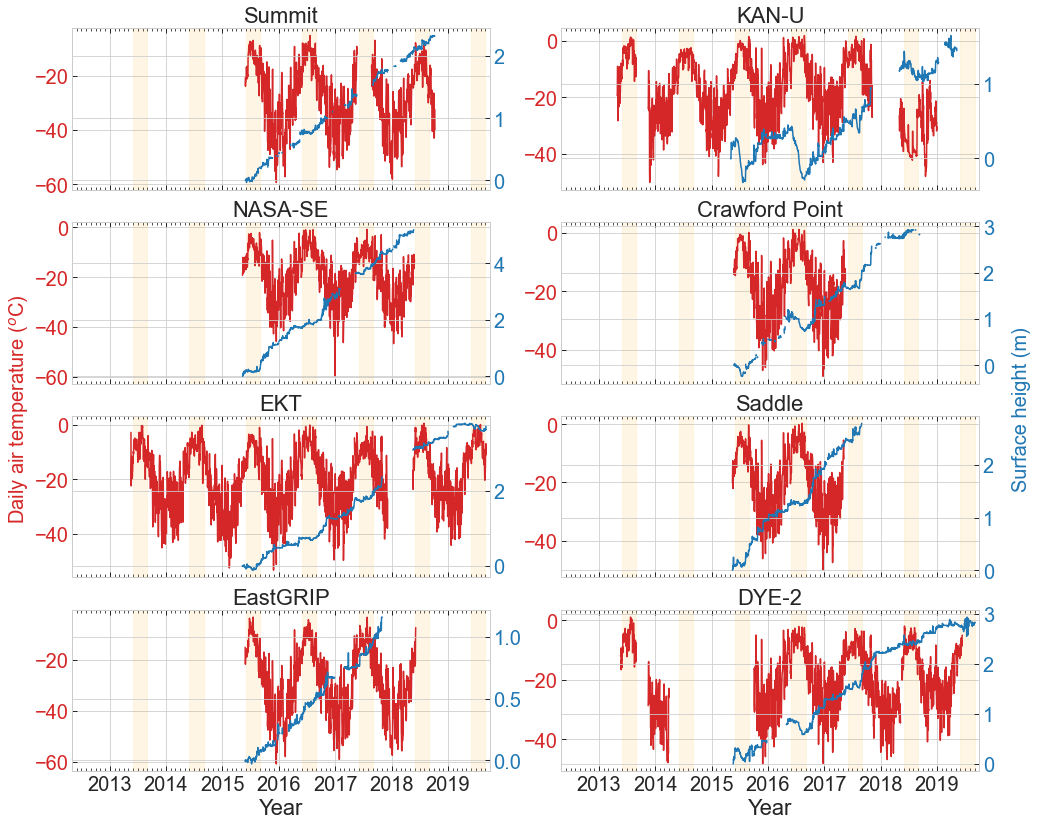

In [27]:
  #%% Air temperature and surface height
airtemp_df = airtemp_df.sort_index()
airtemp_df.loc[pd.IndexSlice['KAN-U', '2013-09-01':'2013-11-15'], 'air_temp_C'] = np.nan
airtemp_df.loc[pd.IndexSlice['KAN-U', '2019-01-01':], 'air_temp_C'] = np.nan 

airtemp_df.loc[pd.IndexSlice['DYE-2', '2013-09-01':'2013-11-15'], 'air_temp_C'] = np.nan 

airtemp_df.loc[pd.IndexSlice['DYE-2' ,'2014-04-01':'2015-10-01'], 'air_temp_C'] = np.nan 
airtemp_df.loc[pd.IndexSlice['DYE-2' ,'2019-06-15':], 'air_temp_C'] = np.nan 

sonic_df = sonic_df.sort_index()
sonic_df.loc[pd.IndexSlice['Summit', '2017-06-01':'2017-09-01'], 'delta'] = np.nan
sonic_df.loc[pd.IndexSlice['EastGrip', '2017-11-01':], 'delta'] = np.nan
sonic_df.loc[pd.IndexSlice['KAN-U', '2017-11-01':'2018-04-01'], 'delta'] = np.nan
sonic_df.loc[pd.IndexSlice['EKT', '2017-11-01':'2018-04-01'], 'delta'] = np.nan

f1, ax = plt.subplots(4,2,figsize=(15, 12))
f1.subplots_adjust(hspace=0.2, wspace=0.17,
                   left = 0.08 , right = 0.92,
                   bottom = 0.08 , top = 0.94)
count = -1
for site in sites:
    print(site)
    count = count+1
    i,j = np.unravel_index(count, ax.shape)
         
    if np.isin(site, airtemp_df.index.get_level_values(0).unique()):
        color1 = 'tab:red'
        ax[i,j].plot(airtemp_df.loc[site,'air_temp_C'].resample('D').mean(),color=color1)
        ax[i,j].set_ylabel('', color=color1)
        ax[i,j].tick_params(axis='y', labelcolor=color1)
    
        ax2 = ax[i,j].twinx()  
        color2 = 'tab:blue'
        ax2.set_ylabel('', color=color2)  
        ax2.plot(-sonic_df.loc[site,'delta'], color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)

        ax[i,j].set_title(site)
        if site == 'Crawford':
            ax[i,j].set_title('Crawford Point')
        if site == 'EastGrip':
            ax[i,j].set_title('EastGRIP')

        ax[i,j].set_xlim([datetime.date(2012, 5, 1), datetime.date(2019, 10, 1)])    
        ax[i,j].xaxis.set_major_locator(years)
        ax[i,j].xaxis.set_major_formatter(years_fmt)
        ax[i,j].xaxis.set_minor_locator(months)
        if i==3:
            ax[i,j].set_xlabel("Year")
        else:
            ax[i,j].set_xlabel("") 
        for k in range(2013,2020):
            ax[i,j].axvspan(*mdates.datestr2num([str(k)+'-06-01', str(k)+'-09-01']), color='orange', alpha=0.1)
        
    if count<len(sites)-2:
        ax[i,j].set_xticklabels("")
f1.text(0.02, 0.5, 'Daily air temperature ($^o$C)', va='center', rotation='vertical', size = 20, color = color1)
f1.text(0.95, 0.5, 'Surface height (m)', va='center', rotation='vertical', size = 20, color = color2)
plt.show()
# f1.savefig('figures/fig6_Ta_HS.tiff', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
# f1.savefig('figures/fig6_Ta_HS.pdf')

Summit
KAN-U
Crawford
-0.57
EKT
Saddle
DYE-2


/var/folders/5q/w3ggb85j2k5gcg7822zwtqmw0000gq/T/ipykernel_29798/214603491.py:71: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = f1.colorbar(cax1, cax=cbar_ax)


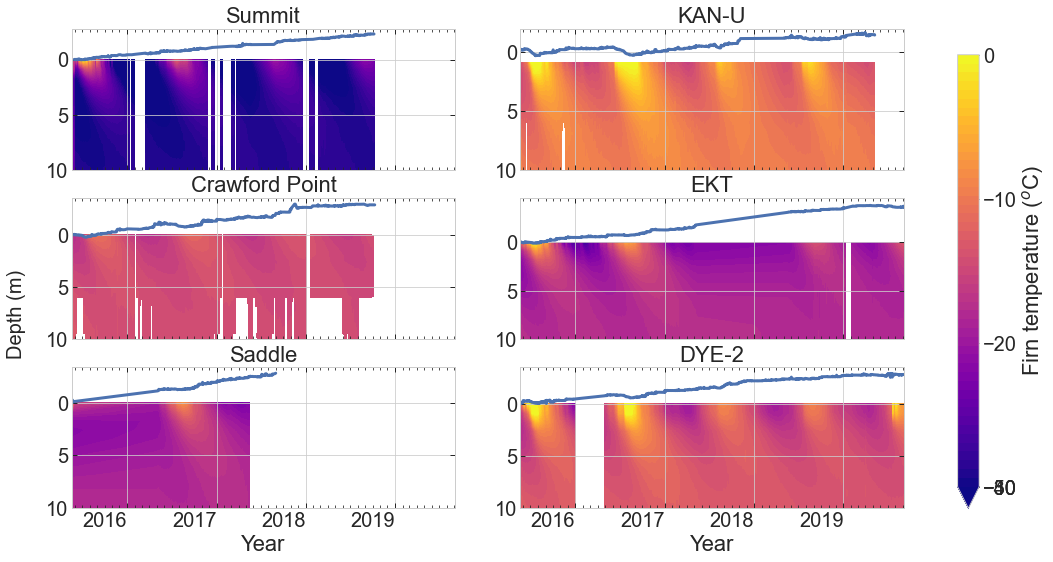

In [28]:
#%% firn temperature

sites2 = sites.copy()
sites2.remove('EastGrip')
sites2.remove('NASA-SE')

f1, ax = plt.subplots(3,2,figsize=(15, 9))
f1.subplots_adjust(hspace=0.2, wspace=0.17,
                   left = 0.08 , right = 0.85 ,
                   bottom = -0.05 , top = 0.94)
count = -1
for site in sites2:
    print(site)
    count = count+1
    i,j = np.unravel_index(count, ax.shape)
    
    sitetemp=rtd_trun.loc[site]
    sitedep = rtd_dep.loc[site]
    n_grid = np.linspace(0,12,15)
    time=sitetemp.index.values
    temps = sitetemp.values
    if site == 'Crawford':
        temps[temps>-0.5]=np.nan    
        print(np.nanmax(temps))
        
    surface_height = sonic_df.loc[site,'delta'].interpolate(limit = 24*7)
    time_surf_height = surface_height.index.get_level_values(0).values
    surface_height = surface_height.loc[ np.isin(time_surf_height, time)]
    temps = temps[np.isin(time, time_surf_height), :]
    time = time[np.isin(time, time_surf_height)]

    time_sitedep = sitedep.index.get_level_values(0).values
    sitedep = sitedep.loc[np.isin(time_sitedep, time)]
    time_sitedep = sitedep.index.get_level_values(0).values
    depths = sitedep.values
    depths = (sitedep.values.T - surface_height.to_numpy()).T
    
    t_interp=np.zeros((depths.shape[0],len(n_grid)))
    for kk in range(depths.shape[0]):
            tif = sp.interpolate.interp1d(depths[kk,:], temps[kk,:], bounds_error=False)
            t_interp[kk,:]= tif(n_grid)
    for kk in range(t_interp.shape[1]):
        t_interp[:,kk] = pd.DataFrame(t_interp[:,kk], time).interpolate(limit = 7).values.reshape(1,-1)
        
    t_interp[t_interp>0]=0
    levels = np.linspace(-30, 0, 50)
    cax1 = ax[i,j].contourf(time,n_grid,t_interp.T, 50,extend = 'min', 
                            levels = levels, zorder=0, 
                            cmap='plasma')
    surface_height.plot(ax=ax[i,j],linewidth=3,rot=0)

    ax[i,j].set_title(site)
    if site == 'Crawford':
        ax[i,j].set_title('Crawford Point')
    if site == 'EastGrip':
        ax[i,j].set_title('EastGRIP')

    ax[i,j].set_ylim( 10, sonic_df.loc[site,'delta'].min()*1.2)
    ax[i,j].set_xlim("2015-05-21", '2019-09-04')
    
    ax[i,j].xaxis.set_major_locator(years)
    ax[i,j].xaxis.set_major_formatter(years_fmt)
    ax[i,j].xaxis.set_minor_locator(months)
    if i==2:
        ax[i,j].set_xlabel("Year")
    else:
        ax[i,j].set_xlabel("")
    if count<len(sites2)-2:
        ax[i,j].set_xticklabels("")
cbar_ax = f1.add_axes([0.9, 0.2, 0.02, 0.7])
cb1 = f1.colorbar(cax1, cax=cbar_ax)
cb1.set_label('Firn temperature ($^o$C)')
cb1.set_ticks([-50, -40, -30, -20, -10, 0])
# f1.text(0.5, 0.02, 'Year', ha='center', size = 20)
f1.text(0.02, 0.5, 'Depth (m)', va='center', rotation='vertical', size = 20)
plt.show()
# f1.savefig('figures/fig6_RTD_temp.tiff', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
#     # plt.close(f1) 

In [29]:
#%% Average temp, average daily compaction

for site in sites:
    print(site)
     
    if np.isin(site, airtemp_df.index.get_level_values(0).unique()):
        ind_instr = inst_meta_df.loc[inst_meta_df['sitename'] == site].index
        df = pd.DataFrame()
        df['Ta_count'] = airtemp_df.loc[site,'air_temp_C'].resample('Y').count()
        df['Ta_mean'] = airtemp_df.loc[site,'air_temp_C'].resample('Y').mean()
        df.loc[df['Ta_count']<365*24*0.9, 'Ta_mean'] = np.nan
        df.drop(columns='Ta_count')
        for instr_nr in ind_instr:
            if np.isin(instr_nr, np.unique(compaction_df.index.get_level_values(0))):
                df[instr_nr] = compaction_df.loc[instr_nr,'daily_compaction_md_smoothed'].resample('Y').mean()
        df.loc['mean'] = df.mean()
        print(df) 

Summit
                     Ta_count    Ta_mean        30        31        32        33        41        50
date                                                                                                
2015-12-31 00:00:00   5196.00        NaN  0.931957  0.485410  0.740374  0.888726       NaN       NaN
2016-12-31 00:00:00   8784.00 -26.163082  0.750901  0.346922  0.566432  0.732417  1.067335       NaN
2017-12-31 00:00:00   6478.00        NaN  0.716114  0.337711  0.544923  0.723673  0.768707  0.946512
2018-12-31 00:00:00   6737.00        NaN  0.607914  0.265278  0.447666  0.615116  0.636528  0.791119
mean                  6798.75 -26.163082  0.751722  0.358830  0.574849  0.739983  0.824190  0.868815
KAN-U
                     Ta_count    Ta_mean         1         2         3        11        35        43
date                                                                                                
2013-12-31 00:00:00    4087.0        NaN  0.000000 -0.009702  0.172638       N

Summit
Average T10: -28.836493
KAN-U
Average T10: -9.548231
Crawford
Average T10: -13.855781
EKT
Average T10: -17.891748
Saddle
Average T10: -17.929508
DYE-2
Average T10: -13.268669


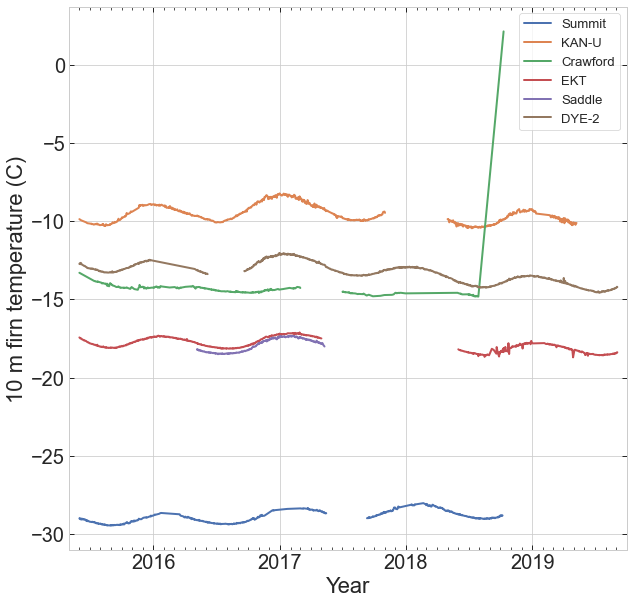

In [30]:
#%% 10 m firn temp
f1, ax = plt.subplots(1,1,figsize=(10, 10))

count = -1
for site in sites2:
    print(site)
    count = count+1
    
    sitetemp=rtd_trun.loc[site]
    sitedep = rtd_dep.loc[site]
    n_grid = np.linspace(0,15,15)
    time=sitetemp.index.values
    temps = sitetemp.values
    
    surface_height = sonic_df.loc[site,'delta']
    time_surf_height = surface_height.index.get_level_values(0).values
    surface_height = surface_height.loc[ np.isin(time_surf_height, time)]

    temps = temps[np.isin(time, time_surf_height), :]
    time = time[np.isin(time, time_surf_height)]

    time_sitedep = sitedep.index.get_level_values(0).values
    sitedep = sitedep.loc[np.isin(time_sitedep, time)]
    time_sitedep = sitedep.index.get_level_values(0).values
    depths = sitedep.values

    depths = (sitedep.values.T - surface_height.to_numpy()).T
    depths_from_surface = (depths.T - surface_height.to_numpy()).T
    T_10m = np.nan*depths_from_surface[:,0]

    for i in range(temps.shape[0]):
        ind_nonan = np.argwhere(np.logical_and(~np.isnan(temps[i,:]), ~np.isnan(depths_from_surface[i,:])))
        if (len(depths_from_surface[i,ind_nonan][:,0])>2 and \
                          len(temps[i,ind_nonan][:,0])>2) and np.max(depths_from_surface[i,ind_nonan][:,0])>10:
            T_10m[i] = sp.interpolate.interp1d(depths_from_surface[i,ind_nonan][:,0],\
                                 temps[i,ind_nonan][:,0], kind='linear',\
                                         assume_sorted=False)(10)
    T_10m[np.argwhere(T_10m>-8)] = np.nan
    if np.sum(np.isnan(T_10m))>1:
        T_10m[np.argwhere(np.isnan(T_10m))]= \
            sp.interpolate.interp1d(np.argwhere(~np.isnan(T_10m))[:,0],\
                                    T_10m[np.argwhere(~np.isnan(T_10m))][:,0], \
                                        fill_value = 'extrapolate') (np.argwhere(np.isnan(T_10m)))
    
    T_10m[np.where(time<np.datetime64('2015-06-01'))] = np.nan
    
    if site == 'Summit':
        ind = np.where(np.logical_and(
            time>np.datetime64('2017-05-15'),
            time<np.datetime64('2017-09-10')))
    if site == 'Saddle':
        ind = np.where( time>np.datetime64('2017-05-10') )
    if site == 'EKT':
        ind = np.where(np.logical_and(
            time>np.datetime64('2017-05-01'),
            time<np.datetime64('2018-06-01')))
    if site == 'Crawford':
        ind1 = np.logical_and(
            time>np.datetime64('2017-03-01'),
            time<np.datetime64('2017-07-01'))
        ind2 = np.logical_and(
            time>np.datetime64('2018-05-01'),
            time<np.datetime64('2017-06-01'))
        ind = np.where(np.logical_or(ind1,ind2))
    if site == 'KAN-U':
        ind = np.where(np.logical_and(
            time>np.datetime64('2017-11-01'),
            time<np.datetime64('2018-05-01')))
    T_10m[ind] = np.nan
    print('Average T10: ' + str(np.nanmean(T_10m)))

    ax.plot(time, T_10m, label=site,linewidth=2)
ax.legend()
ax.set_xlim([datetime.date(2015, 5, 1), datetime.date(2019, 10, 1)])
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.set_xlabel("Year")
ax.set_ylabel('10 m firn temperature (C)')
plt.show()
# f1.savefig('figures/T10.tiff', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
    # plt.close(f1)  

## Start Max's code

In [31]:
# Default Settings for figures
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams["axes.labelsize"] = 22
plt.rcParams['figure.figsize'] = [10, 8]
palette = sns.color_palette()

In [33]:
# Things to change
figex = '_220613.eps' #extension for figures (name plus type)
# pathtodata = '/Users/maxstev/Documents/Grad_School/Research/FIRN/GREENLAND_CVN/Data/CVN_DATA/firncover'
# pathtodata = 'C:\\Users\\dswan1\\Downloads\\CFM'
pathtodata = os.getcwd()
date1 = '2021_07_30' # Date on the hdf5 file

In [34]:
# %matplotlib inline

In [35]:
R          = 8.314                          # gas constant used to calculate Arrhenius's term
S_PER_YEAR = 31557600.0                     # number of seconds in a year
spy = S_PER_YEAR
RHO_1      = 550.0                          # cut off density for the first zone densification (kg/m^3)
RHO_2      = 815.0                          # cut off density for the second zone densification (kg/m^3)
RHO_I      = 917.0                          # density of ice (kg/m^3)
RHO_I_MGM  = 0.917                          # density of ice (g/m^3)
RHO_1_MGM  = 0.550                          # cut off density for the first zone densification (g/m^3)
GRAVITY    = 9.8                            # acceleration due to gravity on Earth
K_TO_C     = 273.15                         # conversion from Kelvin to Celsius
BDOT_TO_A  = S_PER_YEAR * RHO_I_MGM         # conversion for accumulation rate
RHO_W_KGM  = 1000.                          # density of water
P_0 = 1.01325e5

def hl_analytic(rhos0, h, THL, AHL):
    '''
    Model steady-state firn density and age profiles and bubble close-off, uses m w.e. a^-1

    :param rhos0: surface density
    :param h: depth
    :param THL: 
    :param AHL:

    :return age: age vector of firn column with steady-state dynamics
    :return rho: density vector of firn column with steady state dynamics
    '''

    hSize = np.size(h)
    rhos = rhos0 / 1000.0

    A = AHL * RHO_I_MGM
    k0 = 11.0 * np.exp(-10160 / (R * THL))
    k1 = 575.0 * np.exp(-21400 / (R * THL))

    # depth of critical density, eqn 8 from Herron and Langway
    h0_55 = 1 / (RHO_I_MGM * k0) * (np.log(RHO_1_MGM / (RHO_I_MGM - RHO_1_MGM)) - np.log(rhos / (RHO_I_MGM - rhos)))
    Z0 = np.exp(RHO_I_MGM * k0 * h + np.log(rhos / (RHO_I_MGM - rhos)))

    # The boundary from zone 1 to zone 2 = t0_55
    t0_55 = 1 / (k0 * A) * np.log((RHO_I_MGM - rhos) / (RHO_I_MGM - RHO_1_MGM))
    rho_h0 = (RHO_I_MGM * Z0) / (1 + Z0)
    if np.max(rho_h0) >= RHO_I_MGM:
        t0 = np.zeros(hSize)
        for jj in range(hSize):
            if rho_h0[jj] <= RHO_I_MGM - 0.001:
                t0[jj] = (1 / (k0 * A) * np.log((RHO_I_MGM - rhos) / (RHO_I_MGM - rho_h0[jj])))
                jj_max = jj
            else:
                t0[jj] = (t0[jj_max])
    else:
        t0 = 1 / (k0 * A) * np.log((RHO_I_MGM - rhos) / (RHO_I_MGM - rho_h0))

    Z1 = np.exp(RHO_I_MGM * k1 * (h - h0_55) / np.sqrt(A) + np.log(RHO_1_MGM / (RHO_I_MGM - RHO_1_MGM)))
    Z = np.concatenate((Z0[h < h0_55], Z1[h > h0_55]))
    rho_h = (RHO_I_MGM * Z) / (1 + Z)
    tp = np.ones(hSize)
    for j in range(hSize):
        if rho_h[j] < RHO_I_MGM - 0.01:
            tp[j] = 1 / (k1 * np.sqrt(A)) * np.log((RHO_I_MGM - RHO_1_MGM) / (RHO_I_MGM - rho_h[j])) + t0_55
            jMax = j
        else:
            tp[j] = tp[jMax]

    # Zone 1 and Zone 2 repsectively
    age = np.concatenate((t0[h < h0_55], tp[h > h0_55])) * S_PER_YEAR
    rho = rho_h * 1000

    return age, rho

In [36]:
def toYearFraction(date):
    '''
    convert datetime to decimal date 
    '''
    def sinceEpoch(date): # returns seconds since epoch
        return calendar.timegm(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [37]:
def smooth(x,window_len=14,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')

    return y[int(window_len/2-1):-int(window_len/2)]

def butter_lowpass_filter(dd, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sps.butter(order, normal_cutoff, btype='low', analog=False)
    y = sps.filtfilt(b, a, dd)
    return y

def strainfun(arr):
    strain = -1*np.log(arr/arr.iloc[0])
    return strain

In [22]:
# with open('/Users/maxstev/Documents/Grad_School/Research/FIRN/GREENLAND_CVN/Data/CVN_DATA/core_data_dict.pkl','rb') as f:
#     d=pickle.load(f)
# core_df = pd.DataFrame.from_dict(d,orient='index')
# core_df.index.name='coreid'

In [38]:
sites=['Summit','KAN-U','NASA-SE','Crawford','EKT','Saddle','EastGrip','DYE-2']

In [39]:
pathtodata

'/Users/cdsteve2/research/firn/firncover'

In [40]:
### Import the core depth/density data.
# with open(os.path.join(pathtodata,'core_data_df.pkl'),'rb') as f:
#     core_df=pickle.load(f)

In [41]:
### Import the FirnCover data tables. 
filename='FirnCoverData_2_0_' + date1 + '.h5'
filepath=os.path.join(pathtodata,filename)
CVNfile=tb.open_file(filepath, mode='r', driver="H5FD_CORE")
datatable=CVNfile.root.FirnCover
epoch =np.datetime64('1970-01-01')

In [42]:
inst_meta_df = pd.DataFrame.from_records(datatable.Compaction_Instrument_Metadata[:])
inst_meta_df.sitename=inst_meta_df.sitename.str.decode("utf-8")
inst_meta_df.set_index('instrument_ID',inplace=True)
# inst_meta_df.loc[7,'borehole_bottom_from_surface_m']

In [43]:
datatable

/FirnCover (Group) 'FirnCover'
  children := ['Air_Temp_Hourly' (Table), 'Compaction_Daily' (Table), 'Compaction_Instrument_Metadata' (Table), 'Firn_Temp_Daily' (Table), 'Meteorological_Daily' (Table), 'Station_Metadata' (Table), 'Station_Visit_Notes' (Table)]

In [44]:
airtemp_df = pd.DataFrame.from_records(datatable.Air_Temp_Hourly[:])
airtemp_df.sitename = airtemp_df.sitename.str.decode("utf-8")
airtemp_df['date'] = pd.to_datetime(airtemp_df.daynumber_YYYYMMDD,format='%Y%m%d')+pd.to_timedelta(airtemp_df.hournumber_HH,unit='h')
airtemp_df.set_index(['sitename','date'],inplace=True)

In [45]:
airtemp_df2 = airtemp_df['air_temp_C']

In [46]:
airtemp_df2.loc['KAN-U'].resample('a').mean()

date
2013-12-31   -22.818296
2014-12-31   -17.317461
2015-12-31   -18.572308
2016-12-31   -14.010118
2017-12-31   -13.957590
2018-12-31   -31.450445
2019-12-31   -63.105392
Freq: A-DEC, Name: air_temp_C, dtype: float32

In [32]:
# compaction_df.head(3)
# inst_meta_df.head(3)

In [47]:
### First set up the compaction data frame, basic.

compaction_df=pd.DataFrame.from_records(datatable.Compaction_Daily[:])
compaction_df.sitename=compaction_df.sitename.str.decode("utf-8")
compaction_df['date']=pd.to_datetime(compaction_df.daynumber_YYYYMMDD.values,format='%Y%m%d')
compaction_df.set_index(['instrument_id','date'],inplace=True)
compaction_df.drop(columns=["compaction_ratio","compaction_wire_correction_ratio","compaction_cable_distance_m"],inplace=True)
compaction_df.sort_index(inplace=True)

uids = compaction_df.index.get_level_values(0).unique()
compaction_df['hole_init_length']=0*compaction_df['compaction_borehole_length_m']
compaction_df['hole_botfromsurf']=0*compaction_df['compaction_borehole_length_m']
compaction_df['hole_topfromsurf']=0*compaction_df['compaction_borehole_length_m']

for ii in uids:
    compaction_df.loc[ii,'hole_init_length'] = -1*inst_meta_df.loc[ii,'borehole_initial_length_m']*np.ones_like(compaction_df.loc[ii,"compaction_borehole_length_m"].values)
    compaction_df.loc[ii,'hole_botfromsurf'] = -1*inst_meta_df.loc[ii,'borehole_bottom_from_surface_m']*np.ones_like(compaction_df.loc[ii,"compaction_borehole_length_m"].values)
    compaction_df.loc[ii,'hole_topfromsurf'] = -1*inst_meta_df.loc[ii,'borehole_top_from_surface_m']*np.ones_like(compaction_df.loc[ii,"compaction_borehole_length_m"].values)
#Filter saddle data.
compaction_df.drop(compaction_df[((compaction_df.sitename=='Saddle')&(compaction_df.index.get_level_values("date")<'2016-01-01'))].index,inplace=True)    

In [58]:
SumIds = compaction_df[compaction_df.sitename=='Summit'].index.get_level_values(0).unique()

In [72]:
S_PER_YEAR

31557600.0

In [80]:
idict = {}
for II in SumIds:
    DFI = compaction_df.loc[II]
    DFI['ccomp'] = DFI['compaction_borehole_length_m'].iloc[0] - DFI['compaction_borehole_length_m']
    dt = (DFI.index[1] - DFI.index[0]).total_seconds()
    deltaL = -1*DFI['compaction_borehole_length_m'].diff()
    deltaL[deltaL>0.002] = np.nan
    DFI['deltaL'] = deltaL
    DFI['comp_rate_yr'] = DFI['deltaL']/dt*S_PER_YEAR
    idict[II] = DFI

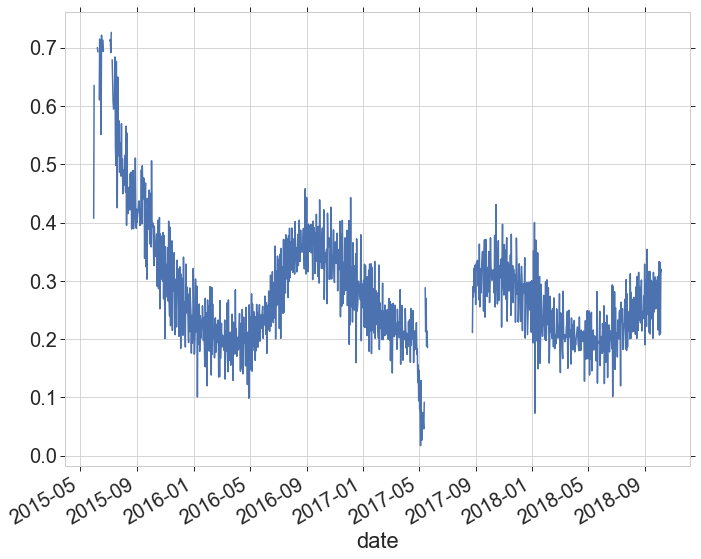

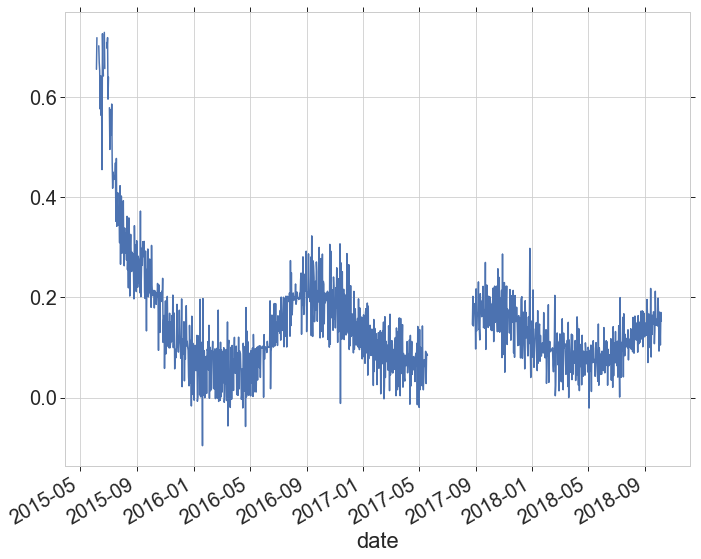

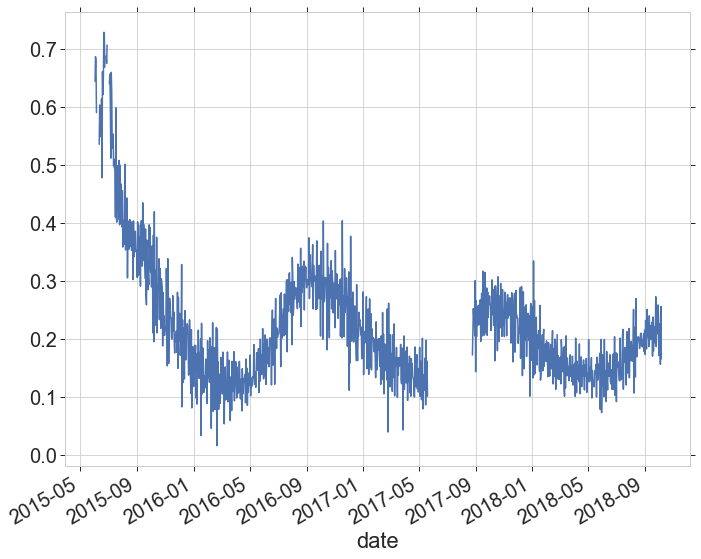

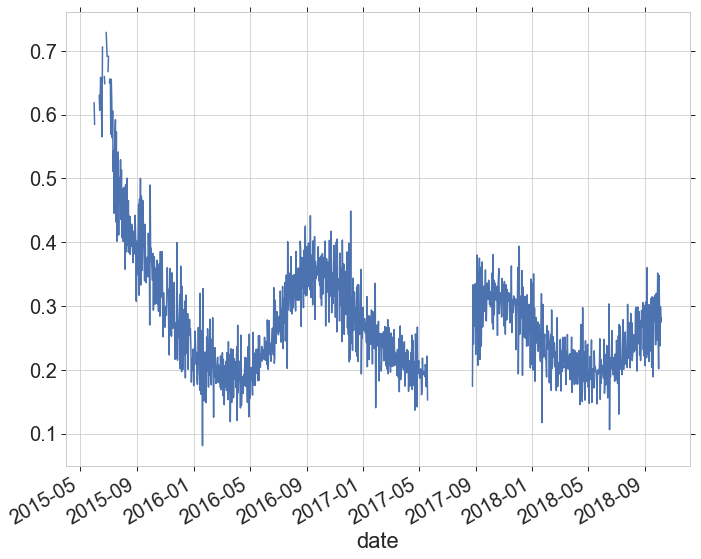

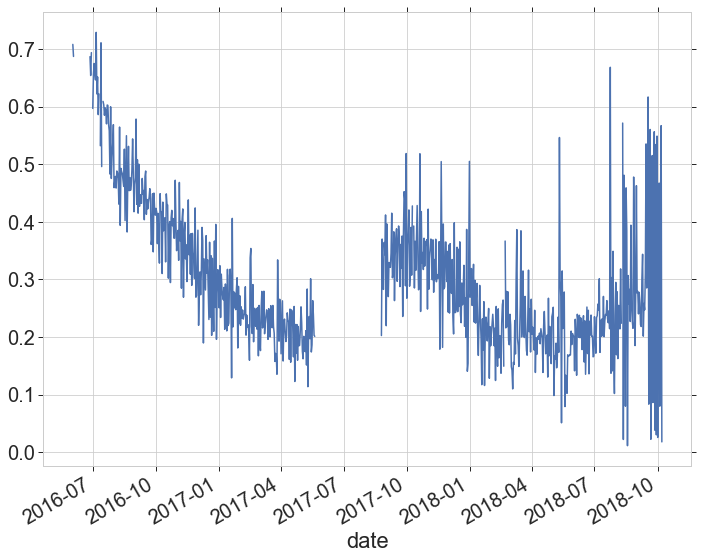

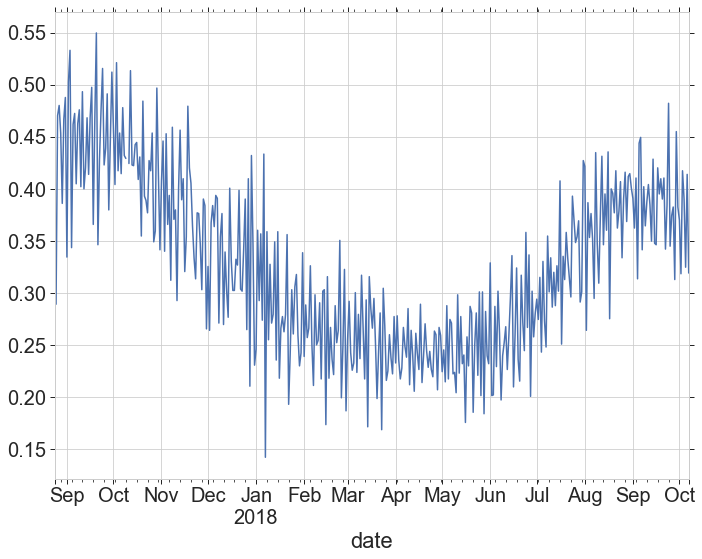

In [81]:
for II in SumIds:
    f1,a1 = plt.subplots()
    d2 = idict[II]
    d2['comp_rate_yr'].plot()

In [35]:
# #Put the 'virtual' holes into the frame (i.e. the differential compaction between holes), Summit, EGRIP only for now.

# ### Summmit
# cd2 = compaction_df.loc[31].copy()
# cd2.hole_init_length = compaction_df.loc[30,'hole_init_length']-compaction_df.loc[31,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[30,'hole_botfromsurf'],compaction_df.loc[31,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[30,'hole_botfromsurf'],compaction_df.loc[31,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[30,'compaction_borehole_length_m']-compaction_df.loc[31,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(101)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# cd2 = compaction_df.loc[31].copy()
# cd2.hole_init_length = compaction_df.loc[30,'hole_init_length']-compaction_df.loc[32,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[30,'hole_botfromsurf'],compaction_df.loc[32,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[30,'hole_botfromsurf'],compaction_df.loc[32,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[30,'compaction_borehole_length_m']-compaction_df.loc[32,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(102)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# cd2 = compaction_df.loc[31].copy()
# cd2.hole_init_length = compaction_df.loc[32,'hole_init_length']-compaction_df.loc[31,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[32,'hole_botfromsurf'],compaction_df.loc[31,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[32,'hole_botfromsurf'],compaction_df.loc[31,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[32,'compaction_borehole_length_m']-compaction_df.loc[31,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(103)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])
# #####

# #### EastGRIP

# # compaction_df.loc[28,'2015-05-28']=compaction_df.loc[28,'2015-05-29']
# # compaction_df.loc[29,'2015-05-28']=compaction_df.loc[29,'2015-05-29']
# compaction_df.drop((27,'2015-05-28'),inplace=True)
# compaction_df.drop((26,'2015-05-28'),inplace=True)

# cd2 = compaction_df.loc[26].copy()
# cd2.hole_init_length = compaction_df.loc[26,'hole_init_length']-compaction_df.loc[28,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[26,'hole_botfromsurf'],compaction_df.loc[28,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[26,'hole_botfromsurf'],compaction_df.loc[28,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[26,'compaction_borehole_length_m']-compaction_df.loc[28,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(104)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# cd2 = compaction_df.loc[26].copy()
# cd2.hole_init_length = compaction_df.loc[26,'hole_init_length']-compaction_df.loc[27,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[26,'hole_botfromsurf'],compaction_df.loc[27,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[26,'hole_botfromsurf'],compaction_df.loc[27,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[26,'compaction_borehole_length_m']-compaction_df.loc[27,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(105)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# cd2 = compaction_df.loc[28].copy()
# cd2.hole_init_length = compaction_df.loc[28,'hole_init_length']-compaction_df.loc[27,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[28,'hole_botfromsurf'],compaction_df.loc[27,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[28,'hole_botfromsurf'],compaction_df.loc[27,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[28,'compaction_borehole_length_m']-compaction_df.loc[27,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(106)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# ### NASA-SE
# cd2 = compaction_df.loc[13].copy()
# cd2.hole_init_length = compaction_df.loc[13,'hole_init_length']-compaction_df.loc[14,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[13,'hole_botfromsurf'],compaction_df.loc[14,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[13,'hole_botfromsurf'],compaction_df.loc[14,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[13,'compaction_borehole_length_m']-compaction_df.loc[14,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(107)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# cd2 = compaction_df.loc[13].copy()
# cd2.hole_init_length = compaction_df.loc[13,'hole_init_length']-compaction_df.loc[15,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[13,'hole_botfromsurf'],compaction_df.loc[15,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[13,'hole_botfromsurf'],compaction_df.loc[15,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[13,'compaction_borehole_length_m']-compaction_df.loc[15,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(108)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# cd2 = compaction_df.loc[13].copy()
# cd2.hole_init_length = compaction_df.loc[15,'hole_init_length']-compaction_df.loc[14,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[15,'hole_botfromsurf'],compaction_df.loc[14,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[15,'hole_botfromsurf'],compaction_df.loc[14,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[15,'compaction_borehole_length_m']-compaction_df.loc[14,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(109)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])
# #######

# ### Crawford
# # 22-24
# cd2 = compaction_df.loc[22].copy()
# cd2.hole_init_length = compaction_df.loc[22,'hole_init_length']-compaction_df.loc[24,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[22,'hole_botfromsurf'],compaction_df.loc[24,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[22,'hole_botfromsurf'],compaction_df.loc[24,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[22,'compaction_borehole_length_m']-compaction_df.loc[24,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(110)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# # 22-25
# cd2 = compaction_df.loc[22].copy()
# cd2.hole_init_length = compaction_df.loc[22,'hole_init_length']-compaction_df.loc[25,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[22,'hole_botfromsurf'],compaction_df.loc[25,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[22,'hole_botfromsurf'],compaction_df.loc[25,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[22,'compaction_borehole_length_m']-compaction_df.loc[25,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(111)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# # 22-23
# cd2 = compaction_df.loc[22].copy()
# cd2.hole_init_length = compaction_df.loc[22,'hole_init_length']-compaction_df.loc[23,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[22,'hole_botfromsurf'],compaction_df.loc[23,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[22,'hole_botfromsurf'],compaction_df.loc[23,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[22,'compaction_borehole_length_m']-compaction_df.loc[23,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(112)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# # 24-25
# cd2 = compaction_df.loc[22].copy()
# cd2.hole_init_length = compaction_df.loc[24,'hole_init_length']-compaction_df.loc[25,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[24,'hole_botfromsurf'],compaction_df.loc[25,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[24,'hole_botfromsurf'],compaction_df.loc[25,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[24,'compaction_borehole_length_m']-compaction_df.loc[25,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(113)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# # 24-23
# cd2 = compaction_df.loc[24].copy()
# cd2.hole_init_length = compaction_df.loc[24,'hole_init_length']-compaction_df.loc[23,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[24,'hole_botfromsurf'],compaction_df.loc[23,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[24,'hole_botfromsurf'],compaction_df.loc[23,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[24,'compaction_borehole_length_m']-compaction_df.loc[23,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(114)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# #25-23
# cd2 = compaction_df.loc[24].copy()
# cd2.hole_init_length = compaction_df.loc[25,'hole_init_length']-compaction_df.loc[23,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[25,'hole_botfromsurf'],compaction_df.loc[23,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[25,'hole_botfromsurf'],compaction_df.loc[23,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[25,'compaction_borehole_length_m']-compaction_df.loc[23,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(115)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])


In [36]:
compaction_df.keys()

Index(['sitename', 'daynumber_YYYYMMDD', 'compaction_borehole_length_m', 'borehole_depth_top_m', 'borehole_depth_bottom_m', 'hole_init_length', 'hole_botfromsurf', 'hole_topfromsurf'], dtype='object')

In [37]:
compaction_df.groupby(level=0)['compaction_borehole_length_m'].apply(lambda x: x.iloc[0]-x)

instrument_id  date      
1              2013-04-29    0.000000
               2013-04-30    0.000813
               2013-05-01    0.001626
               2013-05-02    0.002439
               2013-05-03    0.004064
                               ...   
50             2018-10-03    0.367352
               2018-10-04    0.368420
               2018-10-05    0.369308
               2018-10-06    0.370441
               2018-10-07    0.371315
Name: compaction_borehole_length_m, Length: 54601, dtype: float32

In [38]:
# Now do figure out the compaction rates and strain on all the holes.
compaction_df['compdiff']=compaction_df.groupby(level=0)['compaction_borehole_length_m'].diff()
compaction_df['totcomp']=compaction_df.groupby(level=0)['compaction_borehole_length_m'].apply(lambda x: x.iloc[0]-x)
msk = compaction_df['compdiff']>0
compaction_df.loc[msk,'compdiff']=0
compaction_df['compdiff'].fillna(value=0,inplace=True)
compaction_df['strain']=compaction_df.groupby(level=0)['compaction_borehole_length_m'].apply(strainfun)
compaction_df['ss1970']=(compaction_df.index.get_level_values(1)-epoch).total_seconds()
compaction_df['filtstrain']=0*compaction_df['strain']
compaction_df['strainrate']=0*compaction_df['strain']
compaction_df['filtstrainrate']=0*compaction_df['strain']
compaction_df['comprate']=0*compaction_df['strain']
compaction_df['filttotcomp']=0*compaction_df['strain']
compaction_df['filtcomprate']=0*compaction_df['strain']

uids = compaction_df.index.get_level_values(0).unique()
for ii in uids:
    grad = np.gradient(compaction_df['strain'][ii],compaction_df['ss1970'][ii])
    compaction_df.loc[ii,'strainrate'] = grad # units: per second
    comprate = np.gradient(compaction_df['totcomp'][ii],compaction_df['ss1970'][ii])
    compaction_df.loc[ii,'comprate'] = comprate # units: per second
    try:
        filtstr = smooth(compaction_df['strain'][ii])
        filtgrad = np.gradient(filtstr,compaction_df['ss1970'][ii])
        compaction_df.loc[ii,'filtstrain'] = filtstr # units: per second
        compaction_df.loc[ii,'filtstrainrate'] = filtgrad
        
        filtcomp = smooth(compaction_df['totcomp'][ii])
        filtcomprate = np.gradient(filtcomp,compaction_df['ss1970'][ii])
        compaction_df.loc[ii,'filttotcomp'] = filtcomp # units: per second
        compaction_df.loc[ii,'filtcomprate'] = filtcomprate
    except:
        pass

Text(0, 0.5, 'Compaction Rate (m a$^{-1}$)')

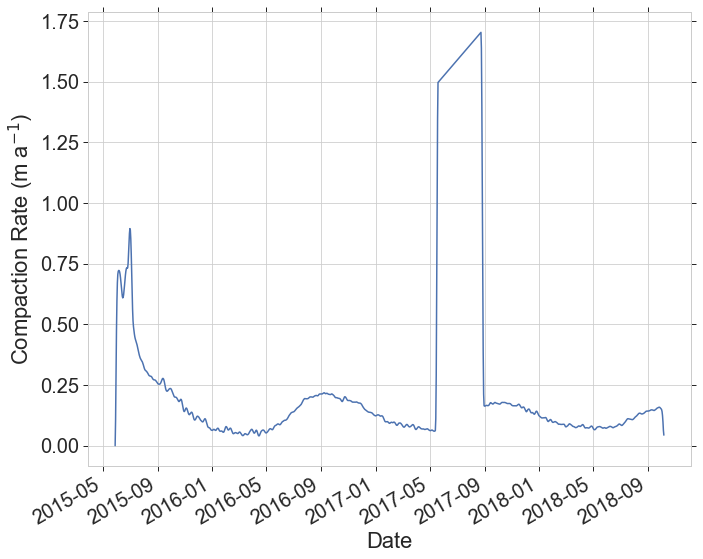

In [39]:
fcr,acr=plt.subplots()
(compaction_df.loc[31,'filtcomprate']*spy).plot(ax=acr)
acr.grid(True)
acr.set_xlabel('Date')
acr.set_ylabel('Compaction Rate (m a$^{-1}$)')

<AxesSubplot:xlabel='date'>

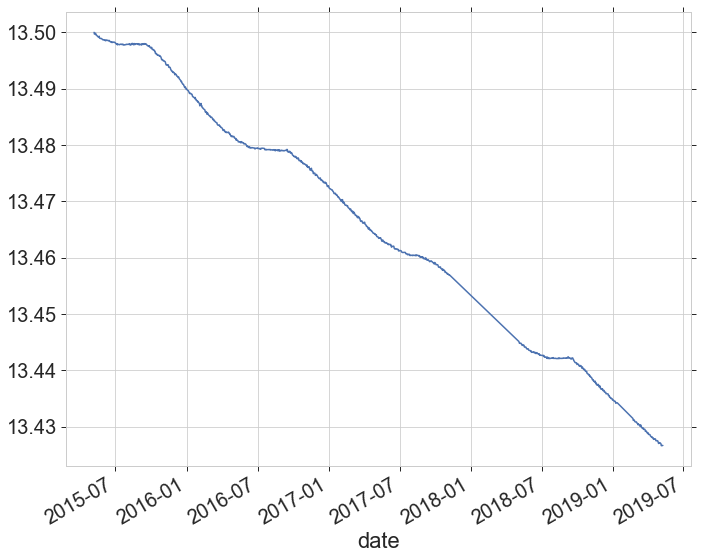

In [40]:
f2,a2=plt.subplots(figsize=(10,8))
(compaction_df.loc[11].compaction_borehole_length_m).plot(ax=a2)

Text(0, 0.5, 'Strain rate')

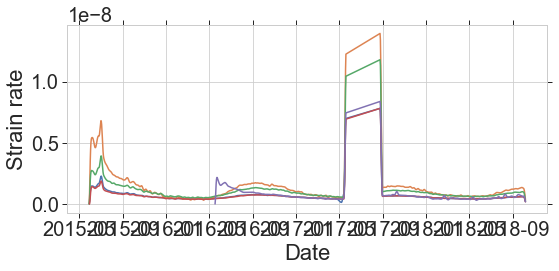

In [41]:
f1,a1 = plt.subplots(figsize=(8,4))
a1.plot(compaction_df.loc[30,'filtstrainrate'])
a1.plot(compaction_df.loc[31,'filtstrainrate'])
a1.plot(compaction_df.loc[32,'filtstrainrate'])
a1.plot(compaction_df.loc[33,'filtstrainrate'])
a1.plot(compaction_df.loc[41,'filtstrainrate'])
a1.grid(True)
a1.set_xlabel('Date')
a1.set_ylabel('Strain rate')

Text(0, 0.5, 'Total Compaction')

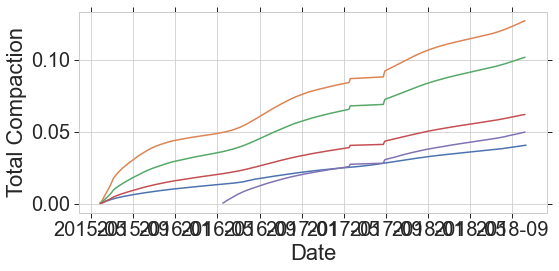

In [42]:
f1,a1 = plt.subplots(figsize=(8,4))
a1.plot(compaction_df.loc[26,'filtstrain'])
a1.plot(compaction_df.loc[31,'filtstrain'])
a1.plot(compaction_df.loc[32,'filtstrain'])
a1.plot(compaction_df.loc[33,'filtstrain'])
a1.plot(compaction_df.loc[41,'filtstrain'])
a1.grid(True)
a1.set_xlabel('Date')
a1.set_ylabel('Total Compaction')

Text(0, 0.5, 'Total Compaction')

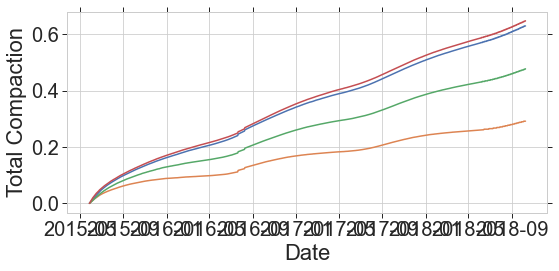

In [43]:
f1,a1 = plt.subplots(figsize=(8,4))
a1.plot(compaction_df.loc[26,'totcomp'])
a1.plot(compaction_df.loc[27,'totcomp'])
a1.plot(compaction_df.loc[28,'totcomp'])
a1.plot(compaction_df.loc[29,'totcomp'])
# a1.plot(compaction_df.loc[41,'totcomp'])
a1.grid(True)
a1.set_xlabel('Date')
a1.set_ylabel('Total Compaction')

In [44]:
compaction_df.head()

sitename  daynumber_YYYYMMDD  compaction_borehole_length_m  borehole_depth_top_m  borehole_depth_bottom_m  hole_init_length  hole_botfromsurf  hole_topfromsurf  compdiff   totcomp    strain        ss1970  filtstrain    strainrate  filtstrainrate      comprate  filttotcomp  filtcomprate
instrument_id date                                                                                                                                                                                                                                                                                                     
1             2013-04-29    KAN-U            20130429                      5.000000                -999.0                   -999.0               5.0               6.2               1.2  0.000000  0.000000 -0.000000  1.367194e+09    0.000341  1.882114e-09    0.000000e+00  9.409807e-09     0.001705  0.000000e+00
              2013-04-30    KAN-U            20130430                      4.999187                -999.0                   -999.0               5.0               6.2               1.2 -0.000813  0.000813  0.000163  1.367280e+09    0.000341  1.881577e-09    3.439477e-10  9.407048e-09     0.001705  1.718684e-09
              2013-05-01    KAN-U            20130501                      4.998374                -999.0                   -999.0               5.0               6.2               1.2 -0.000813  0.001626  0.000325  1.367366e+09    0.000400  1.881884e-09    9.696407e-10  9.407048e-09     0.002002  4.845185e-09
              2013-05-02    KAN-U            20130502                      4.997561                -999.0                   -999.0               5.0               6.2               1.2 -0.000813  0.002439  0.000488  1.367453e+09    0.000509  2.824205e-09    1.439577e-09  1.411195e-08     0.002542  7.193209e-09
              2013-05-03    KAN-U            20130503                      4.995936                -999.0                   -999.0               5.0               6.2               1.2 -0.001626  0.004064  0.000813  1.367539e+09    0.000649  2.824664e-09    1.720788e-09  1.411195e-08     0.003245  8.597875e-09

In [45]:
# df['tvalue'].shift().

In [46]:
df=compaction_df.loc[41].copy()
df['tvalue'] = df.index
df['delta'] = (df['tvalue']-df['tvalue'].shift())#.fillna(0)

In [47]:
statmeta_df=pd.DataFrame.from_records(datatable.Station_Metadata[:].tolist(),columns=datatable.Station_Metadata.colnames)
statmeta_df.sitename=statmeta_df.sitename.str.decode("utf-8")
statmeta_df.iridium_URL=statmeta_df.iridium_URL.str.decode("utf-8")
# pd.to_datetime(compaction_df.daynumber_YYYYMMDD.values,format='%Y%m%d')
statmeta_df['install_date']=pd.to_datetime(statmeta_df.installation_daynumer_YYYYMMDD.values,format='%Y%m%d')
statmeta_df['rtd_date']=pd.to_datetime(statmeta_df.RTD_installation_daynumber_YYYYMMDD.values,format='%Y%m%d')
zz=[]
for ii in range(len(statmeta_df.RTD_depths_at_installation_m[0])):
    st = 'rtd%s' %ii
    zz.append(st)
    
statmeta_df[zz]=pd.DataFrame(statmeta_df.RTD_depths_at_installation_m.values.tolist(),index=statmeta_df.index)  
statmeta_df.set_index('sitename',inplace=True)
statmeta_df.loc['Crawford','rtd_date']=statmeta_df.loc['Crawford','install_date']
statmeta_df.loc['NASA-SE','rtd_date']=statmeta_df.loc['NASA-SE','install_date']-pd.Timedelta(days=1)

In [48]:
airtemp_df=pd.DataFrame.from_records(datatable.Air_Temp_Hourly[:])
airtemp_df.sitename=airtemp_df.sitename.str.decode("utf-8")
# pd.to_datetime(compaction_df.daynumber_YYYYMMDD.values,format='%Y%m%d')
airtemp_df['date']=pd.to_datetime(airtemp_df.daynumber_YYYYMMDD.values*100+airtemp_df.hournumber_HH.values.astype('uint16'),format='%Y%m%d%H')
airtemp_df

,sitename,daynumber_YYYYMMDD,hournumber_HH,air_temp_C,date
0,KAN-U,20130429,17,-14.570000,2013-04-29 17:00:00
1,KAN-U,20130429,18,-15.780000,2013-04-29 18:00:00
2,KAN-U,20130429,19,-17.219999,2013-04-29 19:00:00
3,KAN-U,20130429,20,-19.299999,2013-04-29 20:00:00
4,KAN-U,20130429,21,-21.200001,2013-04-29 21:00:00
...,...,...,...,...,...
264084,EastGrip,20180606,11,-5.767000,2018-06-06 11:00:00
264085,EastGrip,20180606,12,-5.213000,2018-06-06 12:00:00
264086,EastGrip,20180606,13,-5.305000,2018-06-06 13:00:00
264087,EastGrip,20180606,14,-4.975000,2018-06-06 14:00:00


In [49]:
metdata_df=pd.DataFrame.from_records(datatable.Meteorological_Daily[:])
metdata_df.sitename=metdata_df.sitename.str.decode("utf-8")
# pd.to_datetime(compaction_df.daynumber_YYYYMMDD.values,format='%Y%m%d')
metdata_df['date']=pd.to_datetime(metdata_df.daynumber_YYYYMMDD.values,format='%Y%m%d')
for site in sites:
    msk=(metdata_df['sitename']==site)&(metdata_df['date']<statmeta_df.loc[site,'rtd_date'])
    metdata_df.drop(metdata_df[msk].index,inplace=True)
    if site=='NASA-SE':
        # NASA-SE had a new tower section in 5/17; distance raised is ??, use 1.7 m for now. 
        m2 = (metdata_df['sitename']==site)&(metdata_df['date']>'2017-05-10')
        metdata_df.loc[m2,'sonic_range_dist_corrected_m']=metdata_df.loc[m2,'sonic_range_dist_corrected_m']-1.7
    elif site=='Crawford':
        # Crawford has bad sonic data for 11/3/17 to 2/16/18
        m2 = (metdata_df['sitename']==site)&(metdata_df['date']>'2017-11-03')&(metdata_df['date']<'2018-02-16')
        metdata_df.loc[m2,'sonic_range_dist_corrected_m']=np.nan
    elif site=='EKT':
        # EKT had a new tower section in 5/17; distance raised is 0.86 m. 
        m2 = (metdata_df['sitename']==site)&(metdata_df['date']>'2017-05-05')
        metdata_df.loc[m2,'sonic_range_dist_corrected_m']=metdata_df.loc[m2,'sonic_range_dist_corrected_m']-0.86
    elif site=='Saddle':
        # Saddle had a new tower section in 5/17; distance raised is 1.715 m. 
        m2 = (metdata_df['sitename']==site)&(metdata_df['date']>'2017-05-07')
        metdata_df.loc[m2,'sonic_range_dist_corrected_m']=metdata_df.loc[m2,'sonic_range_dist_corrected_m']-1.715
    elif site=='EastGrip':
        # Eastgrip has bad sonic data for 11/7/17 onward 
        m2 = (metdata_df['sitename']==site)&(metdata_df['date']>'2017-11-17')
        metdata_df.loc[m2,'sonic_range_dist_corrected_m']=np.nan
        m3 = (metdata_df['sitename']==site)&(metdata_df['date']>'2015-10-01')&(metdata_df['date']<'2016-04-01')
        metdata_df.loc[m3,'sonic_range_dist_corrected_m']=np.nan
        m4 = (metdata_df['sitename']==site)&(metdata_df['date']>'2016-12-07')&(metdata_df['date']<'2017-03-01')
        metdata_df.loc[m4,'sonic_range_dist_corrected_m']=np.nan
    elif site=='DYE-2':
        # 
        m3 = (metdata_df['sitename']==site)&(metdata_df['date']>'2015-12-24')&(metdata_df['date']<'2016-05-01')
        metdata_df.loc[m3,'sonic_range_dist_corrected_m']=np.nan
#         m4 = (metdata_df['sitename']==site)&(metdata_df['date']>'2016-12-07')&(metdata_df['date']<'2017-03-01')
#         metdata_df.loc[m4,'sonic_range_dist_corrected_m']=np.nan
        
metdata_df.reset_index(drop=True)

,sitename,daynumber_YYYYMMDD,battery_min_V,battery_max_V,panel_temp_mean_C,air_temp_min_C,air_temp_median_C,air_temp_max_C,sonic_range_quality,sonic_range_quality_code,sonic_range_dist_raw_m,sonic_range_air_temp_C,sonic_range_dist_corrected_m,accum_snow_depth_m,accum_snow_depth_interpolated_m,accum_snow_depth_interpolated_flag,date
0,KAN-U,20150505,13.43,14.31,-11.720000,-13.670000,-13.190000,-10.900000,199,0,2.804,-13.670000,2.732935,0.000000,0.000000,0,2015-05-05
1,KAN-U,20150506,13.32,14.93,-9.570000,-16.889999,-10.650000,-6.382000,182,0,2.825,-16.709999,2.737226,-0.004291,-0.004291,0,2015-05-06
2,KAN-U,20150507,13.41,14.84,-7.835000,-15.510000,-11.500000,-3.858000,185,0,2.668,-3.858000,2.649091,0.083844,0.083844,0,2015-05-07
3,KAN-U,20150508,13.43,14.91,-8.830000,-17.469999,-8.620000,-4.530000,185,0,2.693,-17.030001,2.607699,0.125236,0.125236,0,2015-05-08
4,KAN-U,20150509,13.48,14.65,-8.170000,-12.150000,-9.500000,-8.710000,168,0,2.575,-12.150000,2.517079,0.215856,0.215856,0,2015-05-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,EastGrip,20181006,14.05,14.63,-26.610001,-33.340000,-27.209999,-23.700001,170,0,1.673,-25.290001,NaN,1.473876,1.473876,0,2018-10-06
9759,EastGrip,20181007,14.07,14.60,-34.709999,-38.709999,-36.389999,-28.010000,186,0,1.684,-28.010000,NaN,1.472224,1.472224,0,2018-10-07
9760,EastGrip,20181008,14.14,14.60,-32.200001,-36.369999,-33.220001,-28.530001,171,0,1.690,-29.080000,NaN,1.470038,1.470038,0,2018-10-08
9761,EastGrip,20181009,14.12,14.64,-35.009998,-38.459999,-35.169998,-32.730000,198,0,1.710,-34.980000,NaN,1.470789,1.470789,0,2018-10-09


In [50]:
sonic_df = metdata_df[['sitename','date','sonic_range_dist_corrected_m']].set_index(['sitename','date'])
sonic_df.columns = ['sonic_m']
sonic_df.sonic_m[sonic_df.sonic_m<-100]=np.nan
sonic_df.loc['Saddle','2015-05-16']=sonic_df.loc['Saddle','2015-05-17']

for site in sites:
    if site=='Summit':
        sonic_df.loc['Summit','sonic_m']=sonic_df.loc['Summit'].interpolate()
        sonic_df.loc['Summit','sonic_m']=smooth(sonic_df.loc['Summit','sonic_m'].values)
    elif site=='KAN-U':
        gradthresh = 0.1
        vals = sonic_df.loc['KAN-U','sonic_m'].values
        vals[np.isnan(vals)]=-9999
        msk = np.where(np.abs(np.gradient(vals))>=gradthresh)[0]
        vals[msk] = np.nan
        vals[msk-1] = np.nan
        vals[msk+1] = np.nan
        vals[vals==-9999]=np.nan
        sonic_df.loc['KAN-U','sonic_m']=vals
        sonic_df.loc['KAN-U','sonic_m']=sonic_df.loc['KAN-U'].interpolate(method='linear')
        sonic_df.loc['KAN-U','sonic_m']=smooth(sonic_df.loc['KAN-U','sonic_m'].values)
    elif site=='NASA-SE':
        sonic_df.loc['NASA-SE','sonic_m']=sonic_df.loc['NASA-SE'].interpolate()
        sonic_df.loc['NASA-SE','sonic_m']=smooth(sonic_df.loc['NASA-SE','sonic_m'].values)
    elif site=='Crawford':
        gradthresh = 0.1
        vals = sonic_df.loc['Crawford','sonic_m'].values
        vals[np.isnan(vals)]=-9999
        msk = np.where(np.abs(np.gradient(vals))>=gradthresh)[0]
        vals[msk] = np.nan
        vals[msk-1] = np.nan
        vals[msk+1] = np.nan
        vals[vals==-9999]=np.nan
        sonic_df.loc['Crawford','sonic_m']=vals
        sonic_df.loc['Crawford','sonic_m']=sonic_df.loc['Crawford'].interpolate(method='linear')
        sonic_df.loc['Crawford','sonic_m']=smooth(sonic_df.loc['Crawford','sonic_m'].values)
    elif site=='EKT':
        gradthresh = 0.1
        vals = sonic_df.loc['EKT','sonic_m'].values
        vals[np.isnan(vals)]=-9999
        msk = np.where(np.abs(np.gradient(vals))>=gradthresh)[0]
        vals[msk] = np.nan
        vals[msk-1] = np.nan
        vals[msk+1] = np.nan
        vals[vals==-9999]=np.nan
        sonic_df.loc['EKT','sonic_m']=vals
        sonic_df.loc['EKT','sonic_m']=sonic_df.loc['EKT'].interpolate(method='linear')
        sonic_df.loc['EKT','sonic_m']=smooth(sonic_df.loc['EKT','sonic_m'].values)
    elif site=='Saddle':
        gradthresh = 0.1
        vals = sonic_df.loc['Saddle','sonic_m'].values
        vals[np.isnan(vals)]=-9999
        msk = np.where(np.abs(np.gradient(vals))>=gradthresh)[0]
        vals[msk] = np.nan
        vals[msk-1] = np.nan
        vals[msk+1] = np.nan
        vals[vals==-9999]=np.nan
        sonic_df.loc['Saddle','sonic_m']=vals
        sonic_df.loc['Saddle','sonic_m']=sonic_df.loc['Saddle'].interpolate(method='linear')
        sonic_df.loc['Saddle','sonic_m']=smooth(sonic_df.loc['Saddle','sonic_m'].values)
    elif site=='EastGrip':
        gradthresh = 0.1
        vals = sonic_df.loc['EastGrip','sonic_m'].values
        vals[np.isnan(vals)]=-9999
        msk = np.where(np.abs(np.gradient(vals))>=gradthresh)[0]
        vals[msk] = np.nan
        vals[msk-1] = np.nan
        vals[msk+1] = np.nan
        vals[vals==-9999]=np.nan
        sonic_df.loc['EastGrip','sonic_m']=vals
        sonic_df.loc['EastGrip','sonic_m']=sonic_df.loc['EastGrip'].interpolate(method='linear')
        sonic_df.loc['EastGrip','sonic_m']=smooth(sonic_df.loc['EastGrip','sonic_m'].values)
    elif site=='DYE-2':
        gradthresh = 0.1
        vals = sonic_df.loc['DYE-2','sonic_m'].values
        vals[np.isnan(vals)]=-9999
        msk = np.where(np.abs(np.gradient(vals))>=gradthresh)[0]
        vals[msk] = np.nan
        vals[msk-1] = np.nan
        vals[msk+1] = np.nan
        vals[vals==-9999]=np.nan
        sonic_df.loc['DYE-2','sonic_m']=vals
        sonic_df.loc['DYE-2','sonic_m']=sonic_df.loc['DYE-2'].interpolate(method='linear')
        sonic_df.loc['DYE-2','sonic_m']=smooth(sonic_df.loc['DYE-2','sonic_m'].values)
        
for ss in sonic_df.index.unique(level='sitename'):
    dd = statmeta_df.loc[ss]['rtd_date']
    if ss=='Saddle':
        dd = dd + pd.Timedelta('1D')
    sonic_df.loc[ss,'delta']=sonic_df.loc[[ss]].sonic_m-sonic_df.loc[(ss,dd)].sonic_m

In [51]:
sonic_df.loc['EastGrip'].to_pickle('EastGRIP_firncover_sonic.pkl')

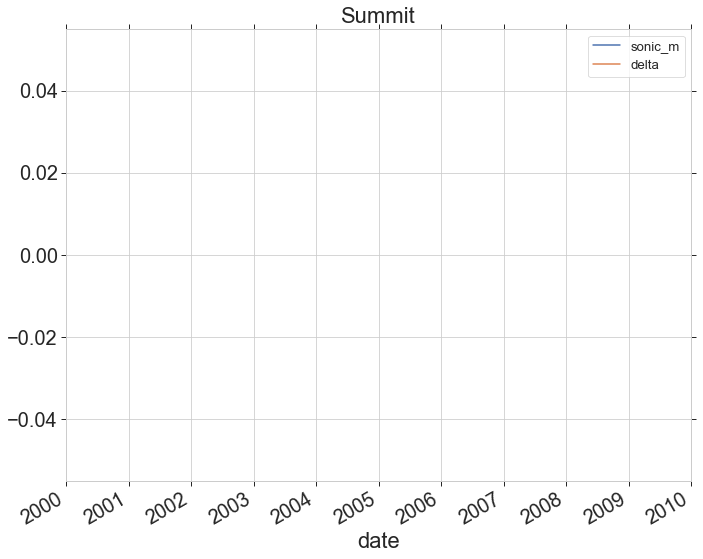

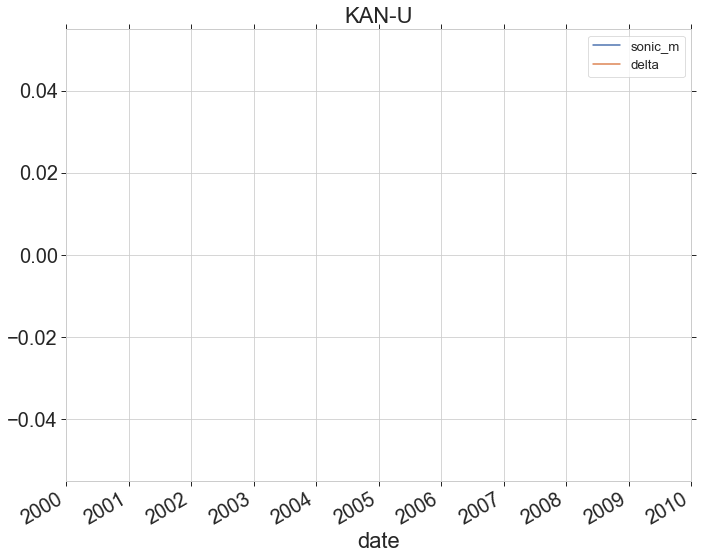

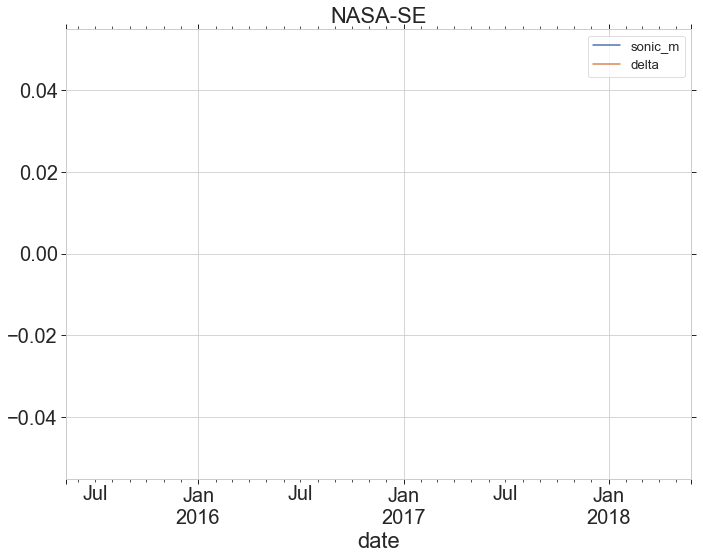

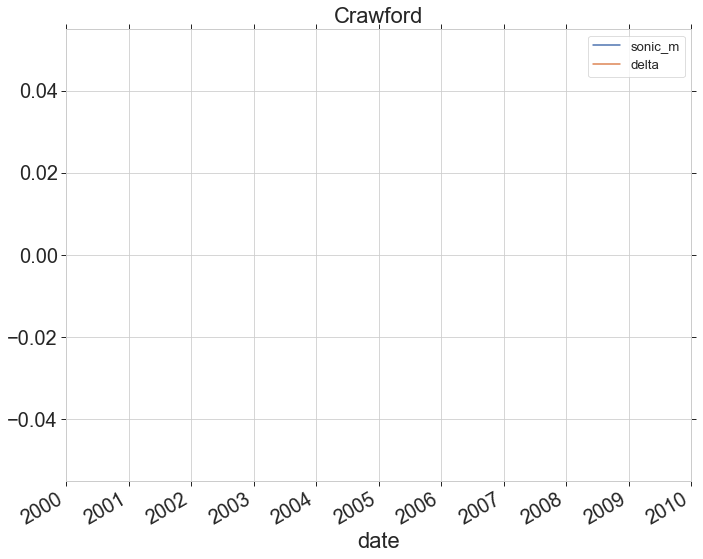

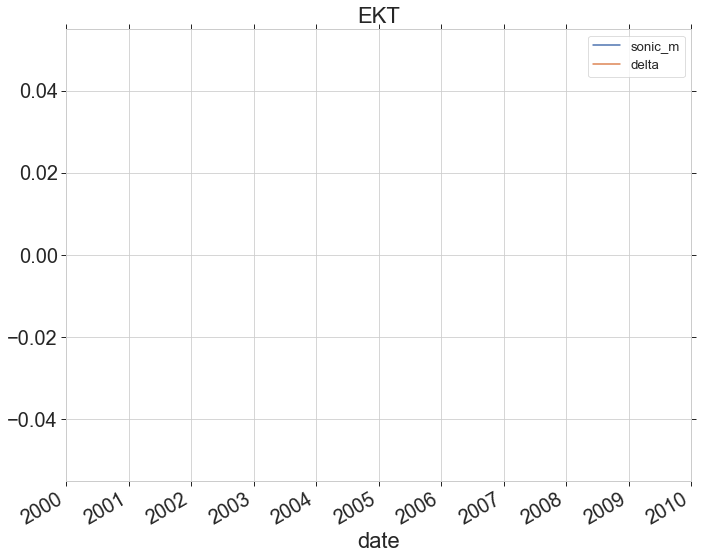

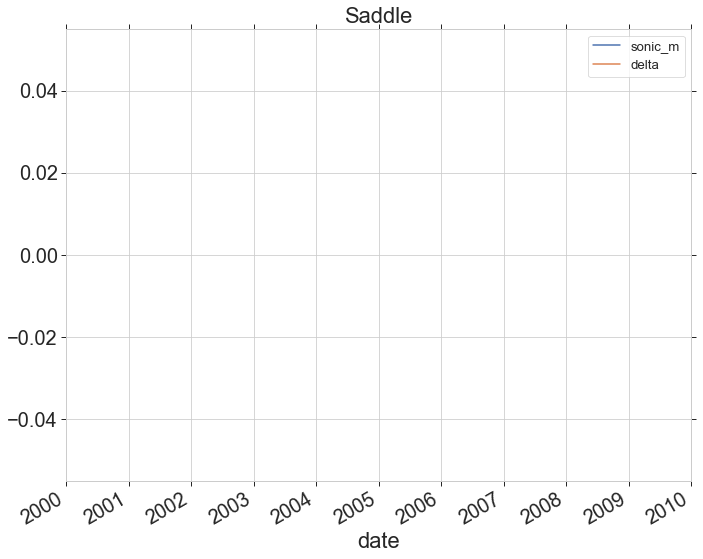

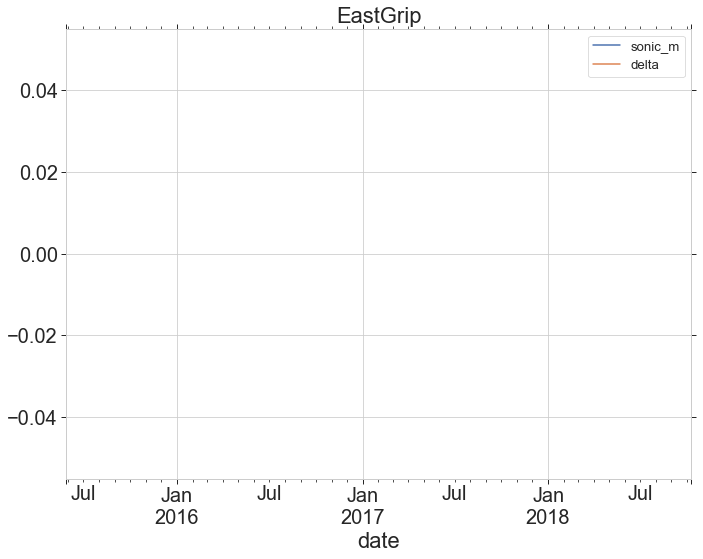

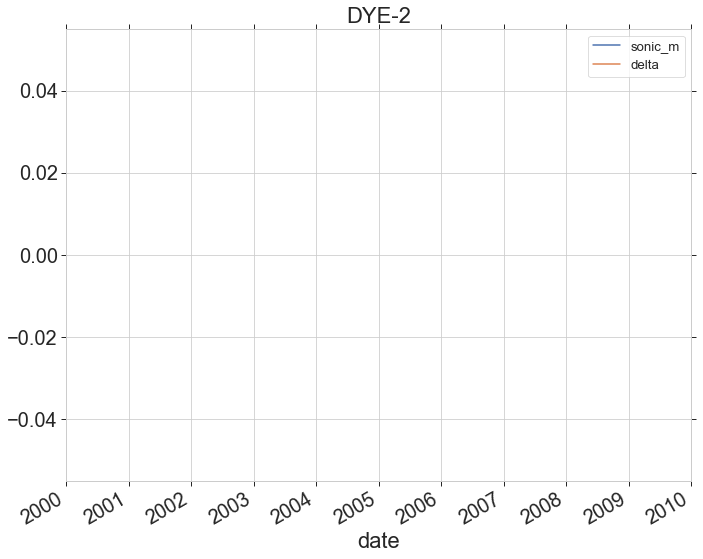

In [52]:
for site in sites:
    sonic_df.loc[site].plot()
    plt.title(site)
    plt.grid(True)

In [53]:
rtd_depth_df=statmeta_df[zz].copy()
xx=statmeta_df.RTD_top_usable_RTD_num
for site in sites:
    vv=rtd_depth_df.loc[site].values
    ri = np.arange(xx.loc[site],24)
    vv[ri]=np.nan
    rtd_depth_df.loc[site]=vv
rtd_d = sonic_df.join(rtd_depth_df, how='inner')
rtd_dc = rtd_d.copy()
rtd_dep = rtd_dc[zz].add(-1*rtd_dc['delta'],axis='rows')

In [54]:
rtd_df=pd.DataFrame.from_records(datatable.Firn_Temp_Daily[:].tolist(),columns=datatable.Firn_Temp_Daily.colnames)
rtd_df.sitename=rtd_df.sitename.str.decode("utf-8")
rtd_df['date']=pd.to_datetime(rtd_df.daynumber_YYYYMMDD.values,format='%Y%m%d')
rtd_df.set_index(['sitename','date'])

daynumber_YYYYMMDD                                       RTD_ohms_avg                                       RTD_ohms_max                         RTD_temp_avg_uncorrected_C                         RTD_temp_max_uncorrected_C  RTD_line_correction_ohms_avg                           RTD_temp_avg_corrected_C                           RTD_temp_max_corrected_C                                       RTD_depths_m
sitename date                                                                                                                                                                                                                                                                                                                                                                                                                             
KAN-U    2015-05-05            20150505  [954.55, 956.88, 958.24, 954.1, 957.67, 958.94...  [969.95, 970.61, 980.14, 965.35, 979.32, 979.1...  [-11.61, -11.02, -10.67, -11.73, -10.81, -10.4...  [-7.68, -7.51, -5.08, -8.86, -5.29, -5.33, -8....                         1.607  [-12.02, -11.43, -11.08, -12.14, -11.22, -10.9...  [-8.09, -7.92, -5.49, -9.27, -5.7, -5.74, -9.3...  [13.51, 12.51, 11.51, 10.51, 9.51, 9.01, 8.51,...
         2015-05-06            20150506  [960.33, 960.63, 961.55, 958.57, 957.99, 958.1...  [982.12, 983.46, 989.56, 977.04, 978.83, 982.7...  [-10.14, -10.06, -9.83, -10.59, -10.73, -10.7,...  [-4.57, -4.23, -2.67, -5.87, -5.41, -4.41, -4....                         1.641  [-10.56, -10.48, -10.24, -11.0, -11.15, -11.12...  [-4.99, -4.65, -3.09, -6.29, -5.83, -4.83, -4....  [13.505709, 12.505709, 11.505709, 10.505709, 9...
         2015-05-07            20150507  [967.72, 967.16, 967.21, 965.06, 963.77, 962.5...  [967.99, 967.5, 967.66, 965.36, 964.05, 962.97...  [-8.25, -8.39, -8.38, -8.93, -9.26, -9.57, -10...  [-8.18, -8.31, -8.27, -8.85, -9.19, -9.46, -9....                         1.661  [-8.67, -8.82, -8.8, -9.35, -9.68, -9.99, -10....  [-8.61, -8.73, -8.69, -9.28, -9.61, -9.89, -10...  [13.593843, 12.593843, 11.593843, 10.593843, 9...
         2015-05-08            20150508  [968.53, 967.98, 967.98, 965.85, 964.58, 963.5...  [969.08, 968.58, 968.58, 966.45, 965.14, 964.1...  [-8.04, -8.18, -8.18, -8.73, -9.05, -9.32, -9....  [-7.9, -8.03, -8.03, -8.57, -8.91, -9.16, -9.5...                         1.642  [-8.46, -8.6, -8.6, -9.15, -9.47, -9.74, -10.1...  [-8.32, -8.45, -8.45, -8.99, -9.33, -9.58, -9....  [13.635237, 12.635237, 11.635237, 10.635237, 9...
         2015-05-09            20150509  [968.57, 968.03, 968.06, 965.9, 964.57, 963.6,...  [968.8, 968.23, 968.39, 966.17, 964.82, 963.79...  [-8.03, -8.17, -8.16, -8.72, -9.05, -9.3, -9.6...  [-7.97, -8.12, -8.08, -8.65, -8.99, -9.25, -9....                         1.648  [-8.45, -8.59, -8.58, -9.14, -9.48, -9.72, -10...  [-8.4, -8.54, -8.5, -9.07, -9.41, -9.67, -10.0...  [13.725857, 12.725857, 11.725857, 10.725857, 9...
...                                 ...                                                ...                                                ...                                                ...                                                ...                           ...                                                ...                                                ...                                                ...
EastGrip 2018-10-06            20181006  [887.5, 887.3, 888.0, 890.0, 892.3, 894.0, 896...  [887.7, 887.6, 888.2, 890.3, 892.4, 894.2, 896...  [-28.67, -28.72, -28.54, -28.03, -27.45, -27.0...  [-28.62, -28.64, -28.49, -27.96, -27.42, -26.9...                         1.387  [-29.02, -29.07, -28.89, -28.38, -27.8, -27.37...  [-28.97, -28.99, -28.84, -28.31, -27.77, -27.3...  [10.473877, 9.473877, 8.473877, 7.4738765, 6.4...
         2018-10-07            20181007  [887.4, 887.3, 888.0, 890.0, 892.3, 894.1, 896...  [887.7, 887.7, 888.3, 890.3, 892.5, 894.3, 896...  [-28.69, -28.72, -28.54, -28.03, -2

In [55]:
rtd_df.head(3)

,sitename,daynumber_YYYYMMDD,RTD_ohms_avg,RTD_ohms_max,RTD_temp_avg_uncorrected_C,RTD_temp_max_uncorrected_C,RTD_line_correction_ohms_avg,RTD_temp_avg_corrected_C,RTD_temp_max_corrected_C,RTD_depths_m,date
0,KAN-U,20150505,"[954.55, 956.88, 958.24, 954.1, 957.67, 958.94...","[969.95, 970.61, 980.14, 965.35, 979.32, 979.1...","[-11.61, -11.02, -10.67, -11.73, -10.81, -10.4...","[-7.68, -7.51, -5.08, -8.86, -5.29, -5.33, -8....",1.607,"[-12.02, -11.43, -11.08, -12.14, -11.22, -10.9...","[-8.09, -7.92, -5.49, -9.27, -5.7, -5.74, -9.3...","[13.51, 12.51, 11.51, 10.51, 9.51, 9.01, 8.51,...",2015-05-05
1,KAN-U,20150506,"[960.33, 960.63, 961.55, 958.57, 957.99, 958.1...","[982.12, 983.46, 989.56, 977.04, 978.83, 982.7...","[-10.14, -10.06, -9.83, -10.59, -10.73, -10.7,...","[-4.57, -4.23, -2.67, -5.87, -5.41, -4.41, -4....",1.641,"[-10.56, -10.48, -10.24, -11.0, -11.15, -11.12...","[-4.99, -4.65, -3.09, -6.29, -5.83, -4.83, -4....","[13.505709, 12.505709, 11.505709, 10.505709, 9...",2015-05-06
2,KAN-U,20150507,"[967.72, 967.16, 967.21, 965.06, 963.77, 962.5...","[967.99, 967.5, 967.66, 965.36, 964.05, 962.97...","[-8.25, -8.39, -8.38, -8.93, -9.26, -9.57, -10...","[-8.18, -8.31, -8.27, -8.85, -9.19, -9.46, -9....",1.661,"[-8.67, -8.82, -8.8, -9.35, -9.68, -9.99, -10....","[-8.61, -8.73, -8.69, -9.28, -9.61, -9.89, -10...","[13.593843, 12.593843, 11.593843, 10.593843, 9...",2015-05-07


In [56]:
rtd_trun = rtd_df[['sitename','date','RTD_temp_avg_corrected_C']].copy().set_index(['sitename','date'])
rtd_trun.columns = ['T_avg']
rtd_trun[zz]=pd.DataFrame(rtd_trun.T_avg.values.tolist(),index=rtd_trun.index)
rtd_trun.drop('T_avg',axis=1,inplace=True)
rtd_trun.replace(-100.0,np.nan,inplace=True)

In [57]:
site='Summit'
sitetemp=rtd_trun.loc[site]
sitedep = rtd_dep.loc[site]
n_grid = np.linspace(-15,3,61)
time1=sitetemp.index.values
temps = sitetemp.values
depths = sitedep.values
rtd_trun.loc[site]

,rtd0,rtd1,rtd2,rtd3,rtd4,rtd5,rtd6,rtd7,rtd8,rtd9,rtd10,rtd11,rtd12,rtd13,rtd14,rtd15,rtd16,rtd17,rtd18,rtd19,rtd20,rtd21,rtd22,rtd23
date,,,,,,,,,,,,,,,,,,,,,,,,
2015-05-29,-23.959999,-23.990000,-23.219999,-23.430000,-23.200001,-24.059999,-24.219999,-25.180000,-24.700001,-25.330000,-25.160000,-26.020000,-24.980000,-25.820000,-25.260000,-17.760000,-17.080000,-14.890000,-8.710000,-12.190000,-10.030000,-8.170000,-11.230000,-8.740000
2015-05-30,-28.930000,-29.049999,-29.230000,-29.639999,-30.120001,-30.370001,-30.700001,-31.129999,-31.590000,-31.840000,-32.070000,-32.349998,-32.270000,-31.620001,-29.049999,-23.110001,-20.600000,-20.629999,-15.700000,-21.000000,-15.580000,-16.510000,-17.680000,-16.480000
2015-05-31,-28.980000,-29.110001,-29.340000,-29.750000,-30.250000,-30.530001,-30.889999,-31.340000,-31.799999,-32.099998,-32.360001,-32.610001,-32.459999,-31.570000,-29.010000,-24.950001,-22.000000,-18.040001,-12.780000,-19.850000,-9.660000,-10.150000,-12.610000,-9.580000
2015-06-01,-28.959999,-29.080000,-29.309999,-29.740000,-30.219999,-30.530001,-30.879999,-31.340000,-31.799999,-32.099998,-32.349998,-32.560001,-32.349998,-31.309999,-29.059999,-25.940001,-22.840000,-18.830000,-16.780001,-20.150000,-14.200000,-15.250000,-16.120001,-14.930000
2015-06-02,-28.910000,-29.059999,-29.290001,-29.719999,-30.200001,-30.480000,-30.860001,-31.320000,-31.750000,-32.049999,-32.279999,-32.480000,-32.200001,-31.139999,-29.160000,-26.469999,-23.170000,-17.969999,-16.080000,-20.040001,-14.290000,-15.450000,-15.330000,-17.139999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-03,-28.780001,-28.830000,-28.830000,-28.830000,-28.650000,-28.500000,-28.299999,-28.100000,-27.820000,-27.459999,-27.000000,-26.549999,-25.959999,-25.250000,-24.459999,-23.799999,-23.270000,-22.840000,-22.889999,-23.090000,-23.070000,-23.090000,-23.139999,-23.250000
2018-10-04,-28.799999,-28.850000,-28.850000,-28.850000,-28.670000,-28.490000,-28.290001,-28.110001,-27.809999,-27.450001,-27.000000,-26.559999,-25.980000,-25.270000,-24.480000,-23.850000,-23.340000,-22.980000,-23.010000,-23.190001,-23.160000,-23.209999,-23.260000,-23.360001
2018-10-05,-28.820000,-28.850000,-28.820000,-28.850000,-28.650000,-28.490000,-28.270000,-28.090000,-27.809999,-27.430000,-26.969999,-26.540001,-25.959999,-25.250000,-24.510000,-23.870001,-23.420000,-23.090000,-23.110001,-23.290001,-23.260000,-23.290001,-23.370001,-23.469999


In [58]:
sitetemp.to_pickle('EGRIP_temp.pkl')
sitedep.to_pickle('EGRIP_rtddep.pkl')

In [59]:
### Use the separate script to plot these.

# for site in sites:
#     print(site)
#     sitetemp=rtd_trun.loc[site]
#     sitedep = rtd_dep.loc[site]
#     n_grid = np.linspace(-15,3,61)
#     time=sitetemp.index.values
#     temps = sitetemp.values
#     depths = sitedep.values
#     ro,co=np.shape(temps)
#     t_interp=np.zeros((ro,len(n_grid)))
#     for kk in range(ro):
#             tif = sp.interpolate.interp1d(depths[kk,:],temps[kk,:],bounds_error=False)
#             t_interp[kk,:]= tif(n_grid)
            
#     f1, ax1 = plt.subplots()
#     f1.set_size_inches(12,6)
#     cax1 = ax1.contourf(time,n_grid,t_interp.T,256, extend='both', vmin=max(-50,np.nanmin(t_interp)),vmax=min(0,np.nanmax(t_interp)))
#     cax1.cmap.set_over('cyan')
#     cax1.cmap.set_under('black')
#     ax1.axhline(y=0,color='k')
#     ax1.set_ylabel('depth')
#     ax1.set_xlabel('date')
#     cb1 = f1.colorbar(cax1)
#     cb1.set_label('Temperature (C)')
#     ax1.set_title(site)
# #     f1.savefig('figures/RTD_temp_%s.eps' %site)
#     plt.close(f1)

In [60]:
# rtd_trun.to_pickle('firncover_rtd_temp.pkl')
# rtd_dep.to_pickle('firncover_rtd_depth.pkl')
compaction_df.to_pickle('firncover_compaction.pkl')

# Now we want to find the viscosity, so we need a mean temperature and density for each measurement.

In [61]:
# t_interp[4:7,:]

In [62]:
site = 'Summit'
sitetemp=rtd_trun.loc[site]
sitedep = rtd_dep.loc[site]
n_grid = np.linspace(-22,0,61)
time=sitetemp.index.values
temps = sitetemp.values
depths = sitedep.values
ro,co=np.shape(temps)
t_interp=np.zeros((ro,len(n_grid)))
for kk in range(ro):
        tif = sp.interpolate.interp1d(depths[kk,:],temps[kk,:],kind='linear',bounds_error=False,fill_value=np.nan)
        try:
            t_interp[kk,:]= tif(n_grid)

            ind = np.where(~np.isnan(t_interp[kk,:]))[0]
            first, last = ind[0], ind[-1]
            t_interp[kk,:first] = t_interp[kk,first]
            t_interp[kk,last + 1:] = t_interp[kk,last]
        except:
            continue
ti_df=pd.DataFrame(data=t_interp,index=rtd_trun.loc['Summit'].index)

site = 'EastGrip'
sitetemp=rtd_trun.loc[site]
sitedep = rtd_dep.loc[site]
n_grid = np.linspace(-22,0,61)
time=sitetemp.index.values
temps = sitetemp.values
depths = sitedep.values
ro,co=np.shape(temps)
t_interp=np.zeros((ro,len(n_grid)))
for kk in range(ro):
        tif = sp.interpolate.interp1d(depths[kk,:],temps[kk,:],kind='linear',bounds_error=False,fill_value=np.nan)
        try:
            t_interp[kk,:]= tif(n_grid)

            ind = np.where(~np.isnan(t_interp[kk,:]))[0]
            first, last = ind[0], ind[-1]
            t_interp[kk,:first] = t_interp[kk,first]
            t_interp[kk,last + 1:] = t_interp[kk,last]
        except:
            continue
ti_df_egr=pd.DataFrame(data=t_interp,index=rtd_trun.loc['EastGrip'].index)

site = 'NASA-SE'
sitetemp=rtd_trun.loc[site]
sitedep = rtd_dep.loc[site]
n_grid = np.linspace(-22,0,61)
time=sitetemp.index.values
temps = sitetemp.values
depths = sitedep.values
ro,co=np.shape(temps)
t_interp=np.zeros((ro,len(n_grid)))
for kk in range(ro):
        tif = sp.interpolate.interp1d(depths[kk,:],temps[kk,:],kind='linear',bounds_error=False,fill_value=np.nan)
        t_interp[kk,:]= tif(n_grid)

        ind = np.where(~np.isnan(t_interp[kk,:]))[0]
        first, last = ind[0], ind[-1]
        t_interp[kk,:first] = t_interp[kk,first]
        t_interp[kk,last + 1:] = t_interp[kk,last]

ti_df_nasa=pd.DataFrame(data=t_interp,index=rtd_trun.loc['NASA-SE'].index)

site = 'Saddle'
sitetemp=rtd_trun.loc[site]
sitedep = rtd_dep.loc[site]
n_grid = np.linspace(-22,0,61)
time=sitetemp.index.values
temps = sitetemp.values
depths = sitedep.values
ro,co=np.shape(temps)
t_interp=np.zeros((ro,len(n_grid)))
for kk in range(ro):
        tif = sp.interpolate.interp1d(depths[kk,:],temps[kk,:],kind='linear',bounds_error=False,fill_value=np.nan)
        t_interp[kk,:]= tif(n_grid)
        try:
            ind = np.where(~np.isnan(t_interp[kk,:]))[0]
            first, last = ind[0], ind[-1]
            t_interp[kk,:first] = t_interp[kk,first]
            t_interp[kk,last + 1:] = t_interp[kk,last]
        except:
            t_interp[kk,:]=np.nan

ti_df_sad=pd.DataFrame(data=t_interp,index=rtd_trun.loc['Saddle'].index)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
deparr = np.arange(0,25,0.1)
sumagehl,sumdenhl = hl_analytic(300,np.arange(0,25,0.1),243,0.23*0.917)
egragehl,egrdenhl = hl_analytic(350,np.arange(0,25,0.1),244,0.14*0.917)
nasaagehl,nasadenhl = hl_analytic(350,np.arange(0,25,0.1),253,0.68*0.917)
sadagehl,saddenhl = hl_analytic(350,np.arange(0,25,0.1),253,0.47*0.917)
crawagehl,crawdenhl = hl_analytic(350,np.arange(0,25,0.1),255,0.5*0.917)
sumageif = sp.interpolate.interp1d(deparr,sumagehl)
egrageif = sp.interpolate.interp1d(deparr,egragehl)
nasaageif = sp.interpolate.interp1d(deparr,nasaagehl)
sadageif = sp.interpolate.interp1d(deparr,nasaagehl)
crawageif = sp.interpolate.interp1d(deparr,nasaagehl)

In [ ]:
core_df['age']=np.zeros_like(core_df.depth)
core_df['lnrho']=np.zeros_like(core_df.depth)
core_df['slope']=np.zeros_like(core_df.depth)

In [ ]:
for core in core_df.xs('Summit',level='site').index.get_level_values(level=0).unique():
    core_df.loc[core,'age']=sumageif(core_df.loc[core,'depth'])
    core_df.loc[core,'lnrho']= -1*np.log(917.0-core_df.loc[core,'density'].values)
    core_df.loc[core,'slope'] = np.polyfit(core_df.loc[core,'age'].values,core_df.loc[core,'lnrho'].values,1)[0]

In [ ]:
summitdf = compaction_df[compaction_df.sitename=='Summit']
sdf2=summitdf.copy()
sdf2['stress']=np.zeros_like(sdf2.hole_init_length)
sdf2['rho']=np.zeros_like(sdf2.hole_init_length)
sdf2['temperature']=np.zeros_like(sdf2.hole_init_length)
sdf2['age']=sumageif(sdf2['hole_botfromsurf'])

for ii in sdf2.index.unique(level='instrument_id'):
    htop = sdf2.loc[ii,'hole_topfromsurf'][0] * -1.0
    hbot = sdf2.loc[ii,'hole_botfromsurf'][0] * -1.0
    qq = ((n_grid<htop) & (n_grid>hbot))
    rr = pd.DataFrame(ti_df.iloc[:,qq].mean(axis=1),columns=['temperature'])
    inter = rr.index.intersection(sdf2.loc[ii].index)
    sdf2.loc[ii,'temperature'] = rr.loc[inter].values.T[0]
    if ii<100:
        sdf2.loc[ii,'stress']=core_df.xs(ii,level='instrument').stress_cu[-1]
        sdf2.loc[ii,'rho']=core_df.xs(ii,level='instrument').density.mean()
    elif ii==101:
        mxx = core_df.xs(31,level='instrument').depth.max()
        sdf2.loc[ii,'stress']=core_df.xs(30,level='instrument').stress_cu[-1]
        sdf2.loc[ii,'rho']=core_df.xs(30,level='instrument')[core_df.xs(30,level='instrument').depth>mxx].density.mean()
    elif ii==102:
        mxx = core_df.xs(32,level='instrument').depth.max()
        sdf2.loc[ii,'stress']=core_df.xs(30,level='instrument').stress_cu[-1]
        sdf2.loc[ii,'rho']=core_df.xs(30,level='instrument')[core_df.xs(30,level='instrument').depth>mxx].density.mean()
    elif ii==103:
        mxx = core_df.xs(31,level='instrument').depth.max()
        sdf2.loc[ii,'stress']=core_df.xs(32,level='instrument').stress_cu[-1]
        sdf2.loc[ii,'rho']=core_df.xs(32,level='instrument')[core_df.xs(32,level='instrument').depth>mxx].density.mean()        

egripdf = compaction_df[compaction_df.sitename=='EastGrip']
egdf2=egripdf.copy()
egdf2['stress']=np.zeros_like(egdf2.hole_init_length)
egdf2['rho']=np.zeros_like(egdf2.hole_init_length)
egdf2['temperature']=np.zeros_like(egdf2.hole_init_length)
egdf2['age']=egrageif(egdf2['hole_botfromsurf'])

for ii in egdf2.index.unique(level='instrument_id'):
    htop = egdf2.loc[ii,'hole_topfromsurf'][0] * -1.0
    hbot = egdf2.loc[ii,'hole_botfromsurf'][0] * -1.0
    qq = ((n_grid<htop) & (n_grid>hbot))
    rr = pd.DataFrame(ti_df_egr.iloc[:,qq].mean(axis=1),columns=['temperature'])
    inter = rr.index.intersection(egdf2.loc[ii].index)
    egdf2.loc[ii,'temperature'] = rr.loc[inter].values.T[0]
    if ii<100:
        egdf2.loc[ii,'stress']=core_df.xs(ii,level='instrument').stress_cu[-2]
        egdf2.loc[ii,'rho']=core_df.xs(ii,level='instrument').density.mean()
    elif ii==104:
        mxx = core_df.xs(28,level='instrument').depth.max()
        egdf2.loc[ii,'stress']=core_df.xs(26,level='instrument').stress_cu[-2]
        egdf2.loc[ii,'rho']=core_df.xs(26,level='instrument')[core_df.xs(26,level='instrument').depth>mxx].density.mean()
    elif ii==105:
        mxx = core_df.xs(27,level='instrument').depth.max()
        egdf2.loc[ii,'stress']=core_df.xs(26,level='instrument').stress_cu[-2]
        egdf2.loc[ii,'rho']=core_df.xs(26,level='instrument')[core_df.xs(26,level='instrument').depth>mxx].density.mean()
    elif ii==106:
        mxx = core_df.xs(27,level='instrument').depth.max()
        egdf2.loc[ii,'stress']=core_df.xs(28,level='instrument').stress_cu[-2]
        egdf2.loc[ii,'rho']=core_df.xs(28,level='instrument')[core_df.xs(28,level='instrument').depth>mxx].density.mean() 
                        
nasadf = compaction_df[compaction_df.sitename=='NASA-SE']
nadf2=nasadf.copy()
nadf2['stress']=np.zeros_like(nadf2.hole_init_length)
nadf2['rho']=np.zeros_like(nadf2.hole_init_length)
nadf2['temperature']=np.zeros_like(nadf2.hole_init_length)
nadf2['age']=nasaageif(nadf2['hole_botfromsurf'])

for ii in nadf2.index.unique(level='instrument_id'):
    htop = nadf2.loc[ii,'hole_topfromsurf'][0] * -1.0
    hbot = nadf2.loc[ii,'hole_botfromsurf'][0] * -1.0
    qq = ((n_grid<htop) & (n_grid>hbot))
    rr = pd.DataFrame(ti_df_nasa.iloc[:,qq].mean(axis=1),columns=['temperature'])
    inter = rr.index.intersection(nadf2.loc[ii].index)
    nadf2.loc[ii,'temperature'] = rr.loc[inter].values.T[0]
    if ii<100:
        nadf2.loc[ii,'stress']=core_df.xs(ii,level='instrument').stress_cu[-2]
        nadf2.loc[ii,'rho']=core_df.xs(ii,level='instrument').density.mean()
    elif ii==107:
        mxx = core_df.xs(14,level='instrument').depth.max()
        nadf2.loc[ii,'stress']=core_df.xs(13,level='instrument').stress_cu[-2]
        nadf2.loc[ii,'rho']=core_df.xs(13,level='instrument')[core_df.xs(13,level='instrument').depth>mxx].density.mean()
    elif ii==108:
        mxx = core_df.xs(15,level='instrument').depth.max()
        nadf2.loc[ii,'stress']=core_df.xs(13,level='instrument').stress_cu[-2]
        nadf2.loc[ii,'rho']=core_df.xs(13,level='instrument')[core_df.xs(13,level='instrument').depth>mxx].density.mean()
    elif ii==109:
        mxx = core_df.xs(14,level='instrument').depth.max()
        nadf2.loc[ii,'stress']=core_df.xs(15,level='instrument').stress_cu[-2]
        nadf2.loc[ii,'rho']=core_df.xs(15,level='instrument')[core_df.xs(15,level='instrument').depth>mxx].density.mean()          
        
saddledf = compaction_df[compaction_df.sitename=='Saddle']
saddf2=saddledf.copy()
saddf2 = saddf2[((saddf2.index.get_level_values("date")>'2016-01-01')&(saddf2.index.get_level_values("date")<'2017-08-21'))]
saddf2['stress']=np.zeros_like(saddf2.hole_init_length)
saddf2['rho']=np.zeros_like(saddf2.hole_init_length)
saddf2['temperature']=np.zeros_like(saddf2.hole_init_length)
saddf2['age']=sadageif(saddf2['hole_botfromsurf'])

for ii in saddf2.index.unique(level='instrument_id'):
    htop = saddf2.loc[ii,'hole_topfromsurf'][0] * -1.0
    hbot = saddf2.loc[ii,'hole_botfromsurf'][0] * -1.0
    qq = ((n_grid<htop) & (n_grid>hbot))
    rr = pd.DataFrame(ti_df_sad.iloc[:,qq].mean(axis=1),columns=['temperature'])
    rr = rr.reindex(saddf2.loc[ii].index,method='nearest')
    inter = rr.index.intersection(saddf2.loc[ii].index)
    saddf2.loc[ii,'temperature'] = rr.loc[inter].values.T[0]
    if ii<100:
        saddf2.loc[ii,'stress']=core_df.xs(ii,level='instrument').stress_cu[-2]
        saddf2.loc[ii,'rho']=core_df.xs(ii,level='instrument').density.mean()

# crawforddf = compaction_df[compaction_df.sitename=='Crawford']
# crawdf2=crawforddf.copy()
# crawdf2 = crawdf2[((crawdf2.index.get_level_values("date")>'2016-01-01')&(crawdf2.index.get_level_values("date")<'2017-08-21'))]
# crawdf2['stress']=np.zeros_like(crawdf2.hole_init_length)
# crawdf2['rho']=np.zeros_like(crawdf2.hole_init_length)
# crawdf2['temperature']=np.zeros_like(crawdf2.hole_init_length)
# crawdf2['age']=crawageif(crawdf2['hole_botfromsurf'])

# for ii in crawdf2.index.unique(level='compaction_instrument_id'):
#     htop = crawdf2.loc[ii,'hole_topfromsurf'][0] * -1.0
#     hbot = crawdf2.loc[ii,'hole_botfromsurf'][0] * -1.0
#     qq = ((n_grid<htop) & (n_grid>hbot))
#     rr = pd.DataFrame(ti_df_craw.iloc[:,qq].mean(axis=1),columns=['temperature'])
#     rr = rr.reindex(crawdf2.loc[ii].index,method='nearest')
#     inter = rr.index.intersection(crawdf2.loc[ii].index)
#     crawdf2.loc[ii,'temperature'] = rr.loc[inter].values.T[0]
#     if ii<100:
#         crawdf2.loc[ii,'stress']=core_df.xs(ii,level='instrument').stress_cu[-2]
#         crawdf2.loc[ii,'rho']=core_df.xs(ii,level='instrument').density.mean()

In [ ]:
dc=dict()
sints_s = [30,31,32,33,101,102,103]
# sints_s = [31]
sints_e = [26,27,28,104,105,106]
sints_n = [13,14,15,107,108,109]
sints_sad = [17,18,19,20]
sints_all = [30,31,32,33,41,101,102,103,26,27,28,40,104,105,106,13,14,15,37,107,108,109]
sints_all = [30,31,32,33,41,101,102,103,26,27,28,40,104,105,106]#,104,108]
rhoi = 917.0
qguess = 60000.0
R = 8.314
for bb in sints_n:
    if bb in sints_s:
        s4=sdf2.loc[bb][['compaction_borehole_length_m','hole_init_length','compdiff','totcomp','stress','rho','temperature','age']]
    elif bb in sints_e:
        s4=egdf2.loc[bb][['compaction_borehole_length_m','hole_init_length','compdiff','totcomp','stress','rho','temperature','age']]
    elif bb in sints_n:
        s4=nadf2.loc[bb][['compaction_borehole_length_m','hole_init_length','compdiff','totcomp','stress','rho','temperature','age']]
    elif bb in sints_sad:
        s4=saddf2.loc[bb][['compaction_borehole_length_m','hole_init_length','compdiff','totcomp','stress','rho','temperature','age']]
    s5=s4.resample('2W').agg({'compaction_borehole_length_m':np.min, 'hole_init_length':np.mean, 'compdiff': np.sum, 'totcomp': np.max, 'stress': np.mean, 'rho': np.mean, 'temperature':np.mean, 'age':np.mean})
    
    # Now do figure out the compaction rates and strain on all the holes.
    # s5['strain']=s5['compaction_borehole_length_m'].apply(strainfun)
    s5['strain'] = -1*np.log(s5['compaction_borehole_length_m']/s5['compaction_borehole_length_m'][0])
    s5['ss1970']=(s5.index-epoch).total_seconds()
    s5['filtstrain']=0*s5['strain']
    s5['strainrate']=0*s5['strain']
    s5['filtstrainrate']=0*s5['strain']
    s5['comprate']=0*s5['strain']
    s5['filttotcomp']=0*s5['strain']
    s5['filtcomprate']=0*s5['strain']

    # uids = s5.index.get_level_values(0).unique()
    # for ii in uids:
    grad = np.gradient(s5['strain'],s5['ss1970'])
    s5['strainrate'] = grad # units: per second
    comprate = np.gradient(s5['totcomp'],s5['ss1970'])
    s5['comprate'] = comprate # units: per second
#     try:
    filtstr = smooth(s5['strain'])
    filtgrad = np.gradient(filtstr,s5['ss1970'])
    s5['filtstrain'] = filtstr # units: per second
    s5['filtstrainrate'] = filtgrad    
    filtcomp = smooth(s5['totcomp'])
    filtcomprate = np.gradient(filtcomp,s5['ss1970'])
    s5['filttotcomp'] = filtcomp # units: per second
    s5['filtcomprate'] = filtcomprate
    s5['srsratio'] = s5.rho * s5.filtstrainrate / s5.stress
    s5['kguess'] = s5.srsratio / ((rhoi-s5.rho) * np.exp(-qguess/(R*(s5.temperature+273.15))))
    s5 = s5[pd.notnull(s5['filtstrainrate'])]
#     except:
#         pass
    dstr = 'df'+str(bb)
    dc[dstr]=s5


In [ ]:
# kg=np.linspace(1.0e-6,3.0e-1,400) # for if we remove the age.
# kg=np.linspace(1e13,1e15,600)
kg=np.linspace(5e9,1e10,600)
q=np.linspace(56000,65000,400)
qt=np.tile(q,(len(kg),1)).T
kt=np.tile(kg,(len(q),1))
Qpref=60000
rmsdict = dict()
rmsexpdict = dict()
krmsd = dict()

blen = sum(len(dc[dct].srsratio) for dct in dc.keys())
minsmat = np.empty((blen,2))
ksmat = np.empty((blen,1))
ll = 0
for jj,key in enumerate(dc.keys()):
#     minsmat = np.empty((len(dc[key].srsratio),2))
#     for ii, val in enumerate(dc[key].srsratio): # option a
    for ii, val in enumerate(dc[key].filtstrainrate): # option b: rms error in m/s
        T = dc[key].temperature[ii]+273.15
#         kqmat = (rhoi-dc[key].rho[ii]) * kt * np.exp(-1*qt/(8.314*T)) #option a
        kqmat = (rhoi-dc[key].rho[ii]) * kt * np.exp(-1*qt/(8.314*T)) * dc[key].stress[ii] / dc[key].rho[ii] / dc[key].age[ii] #option b
        kvec_s = (rhoi-dc[key].rho[ii]) * kg * np.exp(-1*Qpref/(8.314*T)) * dc[key].stress[ii] / dc[key].rho[ii] / dc[key].age[ii] #option b
#         kvec_s = (rhoi-dc[key].rho[ii]) * kg * np.exp(-1*Qpref/(8.314*T)) * dc[key].stress[ii]**2 / dc[key].rho[ii] / dc[key].age[ii]**2 #option b
        rmsdict[ll] = (kqmat - val)**2
        krmsd[ll] = (kvec_s - val)**2
        rmsexpdict[ll] = np.exp(-1*q/(8.314*T))
        if np.isnan(rmsdict[ll]).any():
            print(key)
            print(val)
            print(ll)
        ind = np.unravel_index(np.argmin(rmsdict[ll], axis=None), rmsdict[ll].shape)
        kmin = kt[ind]
        qmin = qt[ind]
        minsmat[ll,0]=kmin
        minsmat[ll,1]=qmin
        
        ind2 = np.argmin(krmsd[ll])
        kmin = kg[ind2]
        ksmat[ll] = kmin
        
        ll+=1
        
v = rmsdict.values()
ke = rmsdict.keys()
rmse = np.sqrt(sum(v)/len(ke))

In [ ]:
f4,a4=plt.subplots()
n, bins, patches=a4.hist(ksmat,20)

In [ ]:
f1,a1 = plt.subplots()
a1.plot(minsmat[:,0],minsmat[:,1],'.')


In [ ]:
cra = np.arange(0,len(minsmat[:,1]))
f3,a3 = plt.subplots()
a3.scatter(minsmat[:,0],minsmat[:,1],c=cra)
# a3.set_xlim(0,1e-3)

In [ ]:
yy=rmse.min()
ex = np.floor(np.log10(np.abs(yy)))
cmax = ((np.ceil(yy/1.0*10**(ex+1)))*1.0*10**(ex+1))/1.1
cmin = ((np.ceil(yy/1.0*10**(ex)))*1.0*10**(ex))*7.5
rmi = rmse.min()
f2,a2 = plt.subplots()
lels = np.linspace(cmin,cmax,41)
cax = a2.contourf(kt,qt,rmse,levels = lels,extend = 'max')
cax.cmap.set_over('white')
a2.set_xlabel('k')
a2.set_ylabel('Q')
plt.colorbar(cax)

In [ ]:
lels=np.linspace(1e-27,1e-20,256)
f10,a10=plt.subplots()
cax = a10.contourf(kg,q,rmsdict[10],levels=lels,extend='max')
plt.colorbar(cax)
a10.set_xlabel('k')
a10.set_ylabel('Q')

In [ ]:
ks = np.array([9.9e8,7.2e9,8.5e9])
acs = np.array([0.68,0.23,0.14])
f8,a8 = plt.subplots()
a8.scatter(acs,ks)

In [ ]:
np.polyfit(acs,ks,1)

In [ ]:
f7,a7=plt.subplots()
a7.plot(sonic_df.loc['NASA-SE'].delta.values)

In [ ]:
summitdf.loc[30]['2016']

In [ ]:
compaction_df[compaction_df.sitename=='Summit'].head()

In [ ]:
f1,a1=plt.subplots()
compaction_df.loc[30].comprate.plot(ax=a1)

In [ ]:
compaction_df.loc[30,'2016-01-01'].totcomp-compaction_df.loc[30,'2016-12-31'].totcomp

In [ ]:
compaction_df.loc[30].resample('a').mean()*spy